## Part 2 Analysis

For HAT-P-20b
* [exoplanet.eu](http://exoplanet.eu/catalog/HAT-P-20_b/)
* [refined transit parameter and TTV](http://iopscience.iop.org/article/10.3847/1538-3881/153/1/28/meta;jsessionid=9BBDAE49F56E6A82A352486336DDA46E.c3.iopscience.cld.iop.org)


For Transit modeling
* Transit and Occultations ([Winn 2010](https://arxiv.org/pdf/1001.2010.pdf))

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

## import lc

In [4]:
import getpass
from tqdm import tqdm

df_g = pd.read_csv('g-band.csv')
df_g = df_g.set_index('BJD(TDB)-2450000')
df_r = pd.read_csv('r-band.csv')
df_r = df_r.set_index('BJD(TDB)-2450000')
df_z = pd.read_csv('z-band.csv')
df_z = df_z.set_index('BJD(TDB)-2450000')

## combined g-,r-,z-band (working light curve)

In [5]:
len(df_g['flux(r=28.0)']), len(df_r['flux(r=28.0)']), len(df_z['flux(r=28.0)'])

(210, 548, 244)

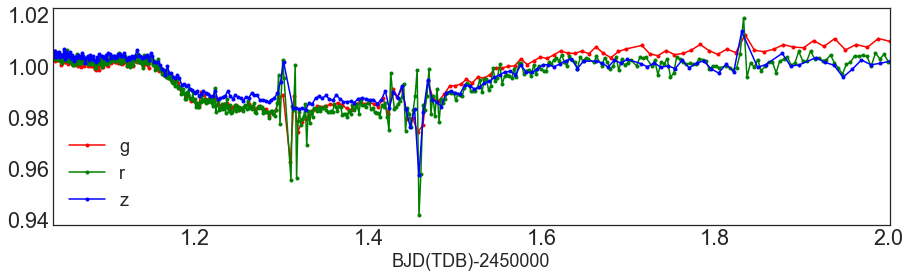

In [6]:
fig,ax = pl.subplots(1,1,figsize=(15,4))

df_g['flux(r=28.0)'].plot(ax=ax, marker='.', label='g', color='r')
df_r['flux(r=28.0)'].plot(ax=ax, marker='.', label='r', color='g')
df_z['flux(r=28.0)'].plot(ax=ax, marker='.', label='z', color='b')
pl.gca().invert_xaxis()
pl.legend()

In [7]:
tc_guess=2.45e6+1.3
df_g = pd.read_csv('g-band.csv')
df_g['BJD(TDB)'] = df_g['BJD(TDB)-2450000'].apply(lambda x: x+2450000)#-tc_guess)
df_g = df_g.set_index('BJD(TDB)')
df_r = pd.read_csv('r-band.csv')
df_r['BJD(TDB)'] = df_r['BJD(TDB)-2450000'].apply(lambda x: x+2450000)#-tc_guess)
df_r = df_r.set_index('BJD(TDB)')
df_z = pd.read_csv('z-band.csv')
df_z['BJD(TDB)'] = df_z['BJD(TDB)-2450000'].apply(lambda x: x+2450000)#-tc_guess)
df_z = df_z.set_index('BJD(TDB)')

## building the model

Known [transit parameters](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=HAT-P-20&type=PLANET_HOST) for modeling HAT-P-20b. See also [exoplanet.org](http://exoplanets.org/detail/HAT-P-20_b).
* Rp/Rs: 0.867 (± 0.033) RJ/ 0.694 (± 0.21) RSun (Rp/Rs=11.23 ± 0.39)
* P:  2.875317 (± 4e-06) d
* a:  0.0361 (± 0.0005) AU
* Tc: 2455080.92661 ± 0.00021 (discovery)
* T14: 0.07700 ± 0.0008 d
* c1,c2:
* b: 0.631 +0.025/-0.028
* inc: 86.80 ± 0.2

* m:  7.246 (± 0.187) MJ

HAT-P-20
* Teff: 4595.0 (± 80.0) K
* M: 0.756 (± 0.028) MS
* logg: 4.63±0.02
* feh: 0.35±0.08
* SpT: K7

### pyTransit

Use pytransit package for transit modeling
* [github](https://github.com/hpparvi/PyTransit)

In [8]:
t = df_g.index

In [9]:
P   = 2.875317 #in days
tc0 = 2.45e6+1.35 #(guess)
inc = np.pi/2 # in radian

## uncertainties package
* [github](https://github.com/lebigot/uncertainties.git)

``` shell
(afapphot) $ pip install git+https://github.com/lebigot/uncertainties
```

In [10]:
from astropy import units as u

#0.867 (± 0.033) RJ/ 0.694 (± 0.21) RSun (Rp/Rs=11.23 ± 0.39)

Rp_jup  = 0.867*u.R_jupiter
uRp_jup = 0.33 *u.R_jupiter
Rs_jup  = 0.694*u.R_sun.to(u.R_jupiter)
uRs_jup = 0.21 *u.R_sun.to(u.R_jupiter)

In [11]:
Rp=Rp_jup.value
uRp=uRp_jup.value

In [12]:
from uncertainties import ufloat

Rp = ufloat(Rp, uRp)
Rs = ufloat(Rs_jup, uRs_jup)

In [13]:
k_=Rp/Rs
k_

0.12841475985235118+/-0.06244136070935906

In [14]:
#ld coeffs
u1,u2= 0.4,-0.1 #random guess

In [15]:
a = ufloat(0.0361, 0.0005)

Rp_au  = 0.867*u.R_jupiter.to(u.au)
uRp_au = 0.33 *u.R_jupiter.to(u.au)

Rs_au = ufloat(Rp_au, uRp_au)
Rs_au

0.000414334533706702+/-0.00015770518583992118

In [16]:
#scaled semi-major axis
a_s_=a/Rs_au
a_s_

87.12766391216226+/-33.184727570929745

In [17]:
(a_s_.nominal_value-a_s_.std_dev,a_s_.nominal_value+a_s_.std_dev)

(53.94293634123252, 120.312391483092)

In [18]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def t14_circ(p, a_s, k, b):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    i = np.arccos(b / a_s)
    alpha = np.sqrt( (1 + k)**2 - b**2 )
    return (p / np.pi) * np.arcsin( alpha / np.sin(i) / a_s )

#k_   = 11.23 
t14_ = 0.07700
#a/Rs
a_s=scaled_a(P, t14_, k_.nominal_value)
a_s

13.428463871114111

In [19]:
b_   = 0.631
inc_ = np.deg2rad(86.80)

a_s_=scaled_a(P, t14_, k_.nominal_value, inc_, b_)
a_s_

11.150098972537233

In [20]:
a_s-a_s_

2.2783648985768785

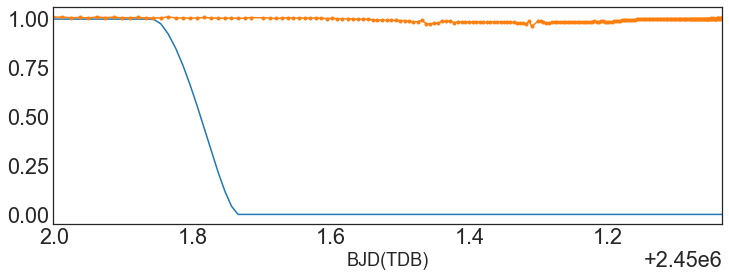

In [22]:
from pytransit import MandelAgol
MA = MandelAgol()

fig,ax=pl.subplots(1,1,figsize=(12,4))
m=MA.evaluate(t, 11, (u1,u2), tc0, P, a_s, i=np.pi/2)
ax.plot(t,m)
df_g['flux(r=28.0)'].plot(marker='.',ax=ax, linestyle=None)
ax.

Use limbdark package to compute theoretical limb darkening coefficients based on stellar parameters
* [github](https://github.com/john-livingston/limbdark)

``` shell
(afapphot) $ pip install git+https://github.com/john-livingston/limbdark
```

Stellar parameters available [here](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=HAT-P-20&type=PLANET_HOST).

In [59]:
import limbdark as ld

teff,uteff=4595.0,80.0
logg,ulogg=4.63,0.02
feh,ufeh=0.35,0.08
wavelength='g*'

u1,uu1,u2,uu2=ld.claret(wavelength, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
u1,uu1,u2,uu2

(0.96050000000000002, 0.029692854497141246, -0.1196, 0.02985153568572143)

In [62]:
from pytransit import MandelAgol
MA = MandelAgol()

q10,q20 = 0.4,0.4
theta = [k_,tc0,a_s_,0.1,q10,q20]

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    k,tc,a,b,q1,q2 = theta[:6]
    inc   = inclination(a, b)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

In [7]:
#k,tc,a,inc,u1,u2
k_   = 0.1343
tc_  = 7800.22 #2455696.93695
impact_param = 0.1
a_   = 0.0509
t14_ = 0.1302
p_   = 4.301219 #pm 0.000019
inc_   = 1.548107 #88.7 deg
q1_, q2_ = 0.4, 0.4

a_scaled_ = scaled_a(p_, t14_, k_, i=inc_, impact_param=impact_param)
theta_true= [k_,tc_,a_scaled_, impact_param, q1_, q2_]

In [8]:
p   = 4.3
inc = inclination(a_scaled_, impact_param) #np.pi/2.0
tc  = 7800.2 #np.mean(ts[0])

k   = [np.sqrt(0.015)] * 3
t14 = t14_circ(p, a_scaled_, k_, impact_param) #[2.8/24] * 3
q1  = [0.4] * 3
q2  = [0.4] * 3
a_s   = []

theta = []

for n,j in enumerate(bands):
    a=scaled_a(p_, t14_, k_, i=np.pi/2, impact_param=impact_param)
    a_s.append(scaled_a(p_, t14_, k_, i=np.pi/2, impact_param=impact_param))
    theta.append([k_,tc_,a,impact_param,q1[n],q2[n]])
    print ("initial guess: {}".format(theta[n]))

initial guess: [0.1343, 7800.22, 11.899237049966159, 0.1, 0.4, 0.4]
initial guess: [0.1343, 7800.22, 11.899237049966159, 0.1, 0.4, 0.4]
initial guess: [0.1343, 7800.22, 11.899237049966159, 0.1, 0.4, 0.4]


In [9]:
ts = [data[b].index for b in bands]
fluxes = [data[b]['flux(r=9.0)'] for b in bands]

In [10]:
from pytransit import MandelAgol
MA = MandelAgol()

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    MA = MandelAgol()
    k,tc,a,b,q1,q2 = theta[:6]
    inc   = inclination(a, b)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

import scipy.optimize as op

def obj(theta, t, f, p):
    '''
    objective function is ordinary least squares
    c.f. chi-quared which includes point-wise sigma
    '''
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [11]:
import scipy.optimize as op

def obj(theta, t, f, p):
    m = model_q(theta, t, p)
    return np.sum((m-f)**2)

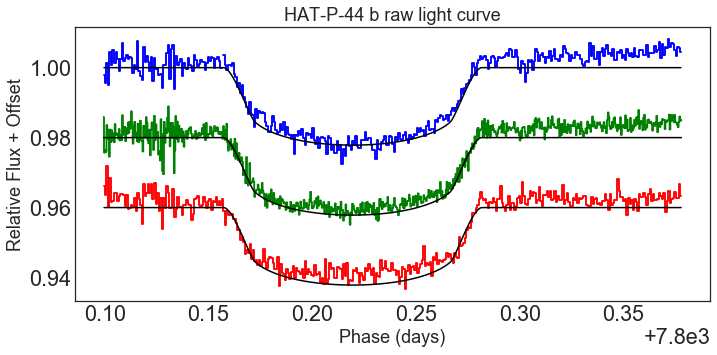

In [12]:
fontsize=18
tc = 7800.22

ts,fluxes=[],[]
airmasses,uncs,peak_fluxes,fwhms,dxs,dys=[],[],[],[],[],[]

colors='b,g,r'.split(',')

data2={} #data with dropped na
fig, axs = plt.subplots(1,1, figsize=(10,5), sharey=True)
for i,b in enumerate(bands):
    d=data[b]
    #remove irrelevant column
    d=d.drop('frame', axis=1)
    #dropna
    d=d.dropna(axis=0)
    #remove outliers
    d=d[np.abs(d-d.mean())<=(3*d.std())]
    #data with dropped na
    data2[b]=d
    
    f=d['flux(r=9.0)']
    t=f.index
    
    ts.append(t)
    fluxes.append(f)
    
    axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    #plt.setp(axs, xlim=t[[0,-1]])
    axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    #
    res = op.minimize(obj, theta[i], args=(t, f, p_), method='nelder-mead')
    model = model_q(res.x, t, p_)
    axs.plot(t, model-0.02*i, 'k-');
    
    fig.tight_layout()

    #sys mod params
    airmasses.append(d['airmass'])
    uncs.append(d['err(r=9.0)'].values)
    peak_fluxes.append(d['peak(ADU)'].values)
    fwhms.append(d['fwhm(pix)'].values)
    dxs.append(d['dx(pix)'].values)
    dys.append(d['dy(pix)'].values)
    
axs.set_title('HAT-P-44 b raw light curve',fontsize=fontsize)
axs.set_ylabel('Relative Flux + Offset',fontsize=fontsize)
axs.set_xlabel('Phase (days)',fontsize=fontsize)

In [13]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, aux_vec, ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[7:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    inv_sig2 = np.exp(-2*ls)
    
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -1681.52736196
NLL after: -2058.38996067
residual: std=0.0024, rms=0.0024
--r--
NLL before: -3151.26073384
NLL after: -3876.90999152
residual: std=0.0023, rms=0.0023
--z--
NLL before: -1704.48132055
NLL after: -2068.78406935
residual: std=0.0023, rms=0.0023


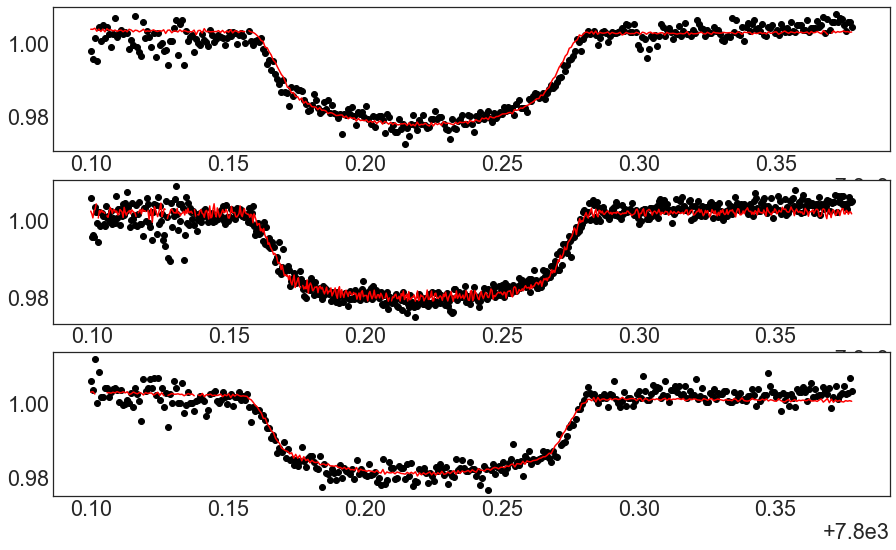

In [14]:
#systematics parameters
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
#log flux uncertainty
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
nparams=5
ip = 0 #impact param, b
#parameters vector: 6 free, 7 input

import scipy.optimize as op
fig = plt.figure(figsize=(15,9))

for n,b in enumerate(sorted(bands)):
    d=data[b]
    #remove irrelevant column
    d=d.drop('frame', axis=1)
    #dropna
    d=d.dropna(axis=0)
    #remove outliers
    d=d[np.abs(d-d.mean())<=(3*d.std())]

    f=d['flux(r=9.0)']
    t=f.index

    #sys mod params
    airmass = d['airmass'].values
    err=d['err(r=9.0)'].values
    peak_flux=d['peak(ADU)'].values
    fwhm = d['fwhm(pix)'].values
    dx = d['dx(pix)'].values
    dy = d['dy(pix)'].values
    print('--{}--'.format(b))
    
    #parameters vector: 6 free, 3 input
    ls = np.log(np.nanstd(f))
    
    a=scaled_a(p_, t14_, k_, impact_param=impact_param, i=np.pi/2)
    theta=[k_,tc_,a,impact_param,q1_,q2_]
    theta_sys = np.concatenate((theta, [ls], k_list[:nparams]))
    #theta = [k,tc,a,inc,u1,u2,ls,k0,k1,k2,k3,k4]
    
    aux_vec = (airmass, dx, dy)
    print ("NLL before: {}".format(nll(theta_sys, t, f, p_, aux_vec)))
    result = op.minimize(nll, theta_sys,    args=(t, f, p_, aux_vec), 
                         method='nelder-mead')
    print ("NLL after: {}".format(nll(result.x,   t, f, p_, aux_vec)))

    f_pred = loglike(result.x, t, f, p_, aux_vec, ret_full=True)
    mod    = loglike(result.x, t, f, p_, aux_vec, ret_mod=True)
    sys    = loglike(result.x, t, f, p_, aux_vec, ret_sys=True)
    resid=f-f_pred
    sigma=np.std(resid)
    rms=np.sqrt(np.mean(resid**2))
    print('residual: std={0:.4f}, rms={1:.4f}'.format(sigma, rms))
    
    ax = plt.subplot(3,1,n+1)
    ax.plot(t, f, 'ko', t, f_pred, 'r-');

## Limb-darkening prior
```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [15]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=5295.0,100.0,2.75,0.07, 0.33,0.1

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [16]:
theta

[0.1343, 7800.22, 11.899237049966159, 0.1, 0.4, 0.4]

In [17]:
from scipy import stats
def logprior(theta,up=None):
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=inclination(a,impact_param)
    
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > 1 or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a   < 0 or a  > 100 or \
        tc < t[0] or tc > t[-1]:
            
        print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    
    return lp

def logprob(theta_sys,ts,fluxes,p,airmasses,dxs,dys,up=None):
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a1,a2,a3,impact_param,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a1,impact_param,q11,q21,ls1,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a2,impact_param,q12,q22,ls2,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a3,impact_param,q13,q23,ls3,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, aux_vec1)
    ll += loglike(theta2, t2, f2, p, aux_vec2)
    ll += loglike(theta3, t3, f3, p, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

sanity check

In [18]:
theta=[]
for n,j in enumerate(bands):
    #a.append(scaled_a(p_, t14_, k_, inc=np.pi/2))
    theta.append([k_,tc_,a,impact_param,q1[n],q2[n]])

k1,k2,k3     = [np.sqrt(0.015)] * 3   
q11,q12, q13 = [0.4] * 3
q21,q22, q23 = [0.4] * 3
a1,a2,a3     = a_s

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5


#log flux uncertainty
ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]  
t1,t2,t3         = ts
f1,f2,f3         = fluxes
xcen1,xcen2,xcen3= dxs
ycen1,ycen2,ycen3= dys
airmass1,airmass2,airmass3=airmasses
#fwhm1,fwhm2,fwhm3= fwhms
#unc1,unc2,unc3   = uncs

In [19]:
theta_sys = [k1,k2,k3,tc,a1,a2,a3,impact_param,q11,q12,q13,q21,q22,q23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,p,airmasses,dxs,dys]

In [20]:
#without ldp
logprob(theta_sys, *args)

6546.8254432054509

In [21]:
#with ldp
logprob(theta_sys, *args, up=ldp)

6498.6808738213786

In [22]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta_sys)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

sampler = EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

#random initial condition
pos0 = sample_ball(theta_sys, [1e-4]*ndim, nwalkers)
'''pos0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in xrange(nwalkers)]'''

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

380it [09:14,  1.41s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


412it [10:07,  1.87s/it]/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/jp/miniconda2/envs/moscatel/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


off limits encountered in logprior


422it [10:22,  1.31s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


448it [11:08,  1.50s/it]

off limits encountered in logprior


456it [11:18,  1.23s/it]

off limits encountered in logprior


459it [11:24,  1.66s/it]

off limits encountered in logprior


469it [11:41,  1.54s/it]

off limits encountered in logprior


473it [11:46,  1.30s/it]

off limits encountered in logprior


475it [11:49,  1.26s/it]

off limits encountered in logprior


480it [12:00,  1.97s/it]

off limits encountered in logprior
off limits encountered in logprior


481it [12:02,  1.89s/it]

off limits encountered in logprior


482it [12:03,  1.74s/it]

off limits encountered in logprior


483it [12:04,  1.63s/it]

off limits encountered in logprior


484it [12:06,  1.58s/it]

off limits encountered in logprior


485it [12:07,  1.52s/it]

off limits encountered in logprior
off limits encountered in logprior


486it [12:09,  1.52s/it]

off limits encountered in logprior
off limits encountered in logprior


487it [12:10,  1.50s/it]

off limits encountered in logprior
off limits encountered in logprior


488it [12:12,  1.47s/it]

off limits encountered in logprior


489it [12:13,  1.43s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


490it [12:15,  1.69s/it]

off limits encountered in logprior
off limits encountered in logprior


491it [12:18,  2.10s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


492it [12:20,  1.96s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


493it [12:22,  1.92s/it]

off limits encountered in logprior
off limits encountered in logprior


494it [12:26,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior


495it [12:27,  2.22s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


496it [12:29,  2.09s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


497it [12:31,  2.09s/it]

off limits encountered in logprior
off limits encountered in logprior


498it [12:34,  2.45s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


499it [12:36,  2.24s/it]

off limits encountered in logprior


500it [12:38,  1.98s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


501it [12:39,  1.79s/it]

off limits encountered in logprior


502it [12:40,  1.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


503it [12:41,  1.55s/it]

off limits encountered in logprior


504it [12:43,  1.46s/it]

off limits encountered in logprior
off limits encountered in logprior


505it [12:44,  1.44s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


506it [12:46,  1.43s/it]

off limits encountered in logprior


507it [12:49,  1.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


508it [12:53,  2.81s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


509it [12:55,  2.49s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


511it [12:58,  1.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior

512it [12:59,  1.80s/it]


off limits encountered in logprior
off limits encountered in logprior


513it [13:01,  1.72s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


514it [13:03,  1.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


515it [13:04,  1.62s/it]

off limits encountered in logprior
off limits encountered in logprior


516it [13:06,  1.60s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


517it [13:09,  2.29s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


518it [13:14,  2.83s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


519it [13:15,  2.49s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


520it [13:17,  2.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


521it [13:18,  1.96s/it]

off limits encountered in logprior


522it [13:20,  1.78s/it]

off limits encountered in logprior


523it [13:21,  1.65s/it]

off limits encountered in logprior
off limits encountered in logprior


524it [13:22,  1.56s/it]

off limits encountered in logprior


525it [13:24,  1.48s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


526it [13:25,  1.48s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


527it [13:27,  1.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


528it [13:31,  2.39s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


529it [13:34,  2.62s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


530it [13:36,  2.25s/it]

off limits encountered in logprior


531it [13:37,  1.96s/it]

off limits encountered in logprior


532it [13:39,  1.90s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


533it [13:42,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


534it [13:44,  2.19s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


535it [13:45,  1.97s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


536it [13:47,  1.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


537it [13:49,  1.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


538it [13:50,  1.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


539it [13:52,  1.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


540it [13:53,  1.59s/it]

off limits encountered in logprior
off limits encountered in logprior


541it [13:55,  1.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


542it [14:00,  2.61s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


543it [14:03,  2.73s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


544it [14:04,  2.30s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


545it [14:06,  2.12s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


546it [14:08,  2.01s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


547it [14:09,  1.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


548it [14:11,  1.74s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


549it [14:12,  1.65s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


550it [14:14,  1.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


551it [14:17,  2.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


552it [14:21,  2.80s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


553it [14:23,  2.51s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


554it [14:25,  2.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


555it [14:27,  2.06s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


556it [14:28,  1.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


557it [14:30,  1.83s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


558it [14:31,  1.77s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


559it [14:33,  1.67s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


560it [14:37,  2.29s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


561it [14:41,  2.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


562it [14:44,  2.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


563it [14:46,  2.57s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


564it [14:47,  2.25s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


565it [14:49,  2.03s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


566it [14:50,  1.93s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


567it [14:52,  1.82s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


568it [14:54,  1.78s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


569it [14:58,  2.57s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


570it [15:02,  3.09s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


571it [15:04,  2.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


572it [15:06,  2.35s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


573it [15:08,  2.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


574it [15:09,  2.06s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


575it [15:11,  1.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


576it [15:12,  1.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


577it [15:14,  1.79s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


578it [15:19,  2.81s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


579it [15:23,  3.03s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


580it [15:25,  2.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


581it [15:26,  2.36s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


582it [15:28,  2.15s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


583it [15:29,  1.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


584it [15:31,  1.83s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


585it [15:33,  1.80s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


586it [15:34,  1.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


587it [15:40,  2.80s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


588it [15:43,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


589it [15:45,  2.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


590it [15:46,  2.31s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


591it [15:50,  2.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


592it [15:52,  2.51s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


593it [15:54,  2.24s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


594it [15:57,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


595it [15:59,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


596it [16:01,  2.22s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


597it [16:03,  2.15s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


598it [16:07,  2.74s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


599it [16:09,  2.39s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


600it [16:10,  2.20s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


601it [16:12,  2.04s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


602it [16:14,  1.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


603it [16:15,  1.79s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


604it [16:17,  1.80s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


605it [16:20,  2.05s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


606it [16:24,  2.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


607it [16:27,  2.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


608it [16:29,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


609it [16:30,  2.24s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


610it [16:32,  2.02s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


611it [16:34,  2.04s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


612it [16:36,  2.11s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


613it [16:38,  1.98s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


614it [16:43,  2.90s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


615it [16:47,  3.11s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


616it [16:48,  2.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


617it [16:50,  2.29s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


618it [16:53,  2.55s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


619it [16:55,  2.49s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


620it [16:57,  2.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


621it [16:59,  2.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


622it [17:03,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


623it [17:04,  2.33s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


624it [17:06,  2.19s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


625it [17:10,  2.78s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


626it [17:12,  2.45s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


627it [17:14,  2.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


628it [17:17,  2.57s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


629it [17:20,  2.56s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


630it [17:21,  2.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


631it [17:23,  2.07s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


632it [17:24,  1.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


633it [17:26,  1.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


634it [17:28,  1.80s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


635it [17:29,  1.71s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


636it [17:32,  2.02s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


637it [17:37,  2.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


638it [17:40,  2.87s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


639it [17:41,  2.51s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior

640it [17:45,  2.71s/it]


off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


641it [17:47,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


642it [17:49,  2.34s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


643it [17:51,  2.23s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


644it [17:55,  2.71s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


645it [17:56,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


646it [17:58,  2.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


647it [18:00,  2.07s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


648it [18:01,  1.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


649it [18:03,  1.86s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


650it [18:05,  1.79s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


651it [18:07,  2.04s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


652it [18:12,  2.87s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


653it [18:15,  2.90s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


654it [18:17,  2.53s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


655it [18:18,  2.23s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


656it [18:23,  2.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


657it [18:24,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


658it [18:26,  2.29s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


659it [18:28,  2.11s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


660it [18:29,  1.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


661it [18:31,  1.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


662it [18:33,  1.78s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


663it [18:35,  2.07s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


664it [18:41,  3.04s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


665it [18:43,  2.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


666it [18:45,  2.60s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


667it [18:47,  2.29s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


668it [18:48,  2.09s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


669it [18:50,  1.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


670it [18:52,  1.90s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


671it [18:53,  1.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


672it [18:57,  2.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


673it [19:01,  2.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


674it [19:03,  2.76s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


675it [19:05,  2.45s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


676it [19:07,  2.31s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


677it [19:09,  2.10s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


678it [19:11,  1.98s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


679it [19:12,  1.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


680it [19:14,  1.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


681it [19:19,  2.74s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


682it [19:23,  3.16s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


683it [19:25,  2.73s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


684it [19:26,  2.40s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


685it [19:28,  2.20s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


686it [19:30,  2.03s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


687it [19:31,  1.90s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


688it [19:33,  1.82s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


689it [19:35,  1.98s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


690it [19:40,  2.96s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


691it [19:43,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


692it [19:45,  2.57s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


693it [19:47,  2.29s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


694it [19:48,  2.05s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


695it [19:50,  1.97s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


696it [19:52,  1.87s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


697it [19:53,  1.83s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


698it [19:57,  2.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


699it [20:02,  3.15s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


700it [20:04,  2.77s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


701it [20:05,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


702it [20:09,  2.74s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


703it [20:12,  2.72s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


704it [20:13,  2.40s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


705it [20:15,  2.30s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


706it [20:19,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


707it [20:20,  2.31s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


708it [20:22,  2.12s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


709it [20:25,  2.39s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


710it [20:28,  2.44s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior

711it [20:29,  2.19s/it]


off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


712it [20:31,  1.99s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


713it [20:32,  1.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


714it [20:35,  2.13s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


715it [20:37,  2.03s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


716it [20:38,  1.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


717it [20:44,  2.99s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


718it [20:47,  3.10s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


719it [20:49,  2.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


720it [20:50,  2.31s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


721it [20:55,  2.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


722it [20:56,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


723it [20:58,  2.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


724it [21:02,  2.72s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


725it [21:04,  2.54s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


726it [21:05,  2.28s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


727it [21:09,  2.60s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


728it [21:11,  2.57s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


729it [21:13,  2.28s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


730it [21:15,  2.11s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


731it [21:16,  1.98s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


732it [21:18,  1.86s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


733it [21:19,  1.78s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


734it [21:21,  1.72s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


735it [21:23,  1.76s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


736it [21:28,  2.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


737it [21:31,  2.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


738it [21:33,  2.48s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


739it [21:34,  2.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


740it [21:39,  2.82s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


741it [21:40,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


742it [21:42,  2.18s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


743it [21:45,  2.42s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


744it [21:47,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


745it [21:49,  2.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


746it [21:50,  1.96s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


747it [21:52,  1.81s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


748it [21:53,  1.71s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


749it [21:55,  1.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


750it [21:56,  1.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


751it [21:58,  1.59s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


752it [22:02,  2.28s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


753it [22:06,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


754it [22:08,  2.61s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


755it [22:10,  2.31s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


756it [22:13,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


757it [22:15,  2.58s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


758it [22:17,  2.33s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


759it [22:19,  2.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


760it [22:23,  2.65s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


761it [22:24,  2.34s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


762it [22:26,  2.15s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


763it [22:29,  2.51s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


764it [22:32,  2.42s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


765it [22:34,  2.34s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


766it [22:37,  2.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


767it [22:40,  2.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


768it [22:41,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


769it [22:44,  2.53s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


770it [22:47,  2.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


771it [22:49,  2.43s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


772it [22:52,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


773it [22:55,  2.71s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


774it [22:57,  2.38s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


775it [22:58,  2.14s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


776it [23:02,  2.59s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


777it [23:04,  2.38s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


778it [23:06,  2.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


779it [23:09,  2.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


780it [23:12,  2.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


781it [23:14,  2.40s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


782it [23:17,  2.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


783it [23:20,  2.62s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


784it [23:21,  2.35s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


785it [23:24,  2.45s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


786it [23:27,  2.70s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


787it [23:29,  2.38s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


788it [23:30,  2.14s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


789it [23:32,  2.01s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


790it [23:34,  1.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


791it [23:36,  1.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


792it [23:37,  1.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


793it [23:39,  1.71s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


794it [23:44,  2.78s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


795it [23:47,  2.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


796it [23:49,  2.52s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


797it [23:50,  2.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


798it [23:54,  2.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


799it [23:56,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


800it [23:58,  2.22s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


801it [24:01,  2.52s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


802it [24:04,  2.62s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

803it [24:06,  2.39s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

804it [24:08,  2.23s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


805it [24:09,  2.08s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


806it [24:11,  1.97s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

807it [24:13,  1.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

808it [24:15,  2.10s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


809it [24:21,  3.06s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


810it [24:24,  3.05s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


811it [24:25,  2.60s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


812it [24:27,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


813it [24:31,  2.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

814it [24:34,  2.73s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

815it [24:36,  2.59s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


816it [24:37,  2.33s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


817it [24:39,  2.19s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

818it [24:41,  2.07s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


819it [24:43,  1.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

820it [24:48,  3.00s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


821it [24:52,  3.08s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

822it [24:53,  2.71s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


823it [24:55,  2.42s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


824it [24:57,  2.19s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


825it [24:59,  2.08s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


826it [25:00,  1.97s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


827it [25:02,  1.87s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


828it [25:06,  2.41s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


829it [25:11,  3.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


830it [25:13,  2.81s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

831it [25:14,  2.51s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

832it [25:16,  2.25s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


833it [25:18,  2.07s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


834it [25:19,  1.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

835it [25:21,  1.83s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

836it [25:23,  1.78s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

837it [25:27,  2.68s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


838it [25:31,  3.02s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


839it [25:33,  2.64s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

840it [25:35,  2.34s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

841it [25:36,  2.18s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

842it [25:38,  2.02s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

843it [25:40,  1.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


844it [25:41,  1.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

845it [25:44,  2.17s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


846it [25:49,  3.06s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

847it [25:52,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


848it [25:54,  2.58s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


849it [25:57,  2.73s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

850it [26:00,  2.79s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


851it [26:02,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

852it [26:05,  2.70s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

853it [26:08,  2.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

854it [26:10,  2.56s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


855it [26:13,  2.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

856it [26:16,  2.77s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

857it [26:18,  2.44s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


858it [26:20,  2.43s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

859it [26:23,  2.72s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


860it [26:25,  2.45s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


861it [26:27,  2.20s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

862it [26:31,  2.82s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

863it [26:33,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


864it [26:35,  2.36s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


865it [26:37,  2.19s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


866it [26:38,  2.00s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

867it [26:40,  1.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

868it [26:42,  1.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

869it [26:47,  2.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


870it [26:51,  3.30s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

871it [26:53,  2.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

872it [26:55,  2.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

873it [26:59,  3.12s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

874it [27:01,  2.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

875it [27:03,  2.37s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

876it [27:07,  3.06s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

877it [27:09,  2.67s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

878it [27:11,  2.41s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

879it [27:15,  2.99s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

880it [27:17,  2.67s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

881it [27:19,  2.43s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

882it [27:23,  3.04s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

883it [27:25,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

884it [27:27,  2.36s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

885it [27:31,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

886it [27:33,  2.63s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

887it [27:35,  2.42s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

888it [27:39,  2.98s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior


889it [27:41,  2.59s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

890it [27:43,  2.39s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

891it [27:47,  3.01s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

892it [27:50,  2.75s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

893it [27:52,  2.74s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

894it [27:56,  2.97s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

895it [27:58,  2.70s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

896it [28:01,  2.80s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

897it [28:04,  2.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

898it [28:06,  2.54s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

899it [28:09,  2.79s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

900it [28:12,  2.79s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

901it [28:14,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

902it [28:15,  2.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

903it [28:17,  2.13s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

904it [28:19,  1.99s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

905it [28:21,  1.93s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

906it [28:23,  1.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

907it [28:28,  2.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

908it [28:32,  3.25s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

909it [28:34,  2.97s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

910it [28:36,  2.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

911it [28:38,  2.42s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

912it [28:40,  2.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

913it [28:42,  2.18s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

914it [28:45,  2.55s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

915it [28:50,  3.26s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

916it [28:53,  3.04s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

917it [28:54,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

918it [28:59,  3.17s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

919it [29:01,  2.81s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

920it [29:03,  2.53s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

921it [29:07,  3.15s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

922it [29:09,  2.77s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

923it [29:11,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

924it [29:16,  3.21s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

925it [29:18,  2.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

926it [29:21,  3.04s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

927it [29:24,  3.01s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

928it [29:26,  2.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

929it [29:30,  3.05s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

930it [29:32,  2.81s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

931it [29:34,  2.51s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

932it [29:36,  2.34s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

933it [29:38,  2.25s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

934it [29:40,  2.15s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

935it [29:42,  2.02s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

936it [29:46,  2.60s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

937it [29:51,  3.34s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

938it [29:53,  2.89s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

939it [29:54,  2.55s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

940it [29:59,  3.17s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

941it [30:01,  2.76s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

942it [30:02,  2.41s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

943it [30:07,  3.00s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

944it [30:09,  2.71s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

945it [30:11,  2.46s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

946it [30:15,  3.06s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

947it [30:17,  2.69s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

948it [30:19,  2.38s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

949it [30:20,  2.23s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

950it [30:22,  2.12s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

951it [30:24,  2.02s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

952it [30:26,  1.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

953it [30:30,  2.55s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

954it [30:35,  3.27s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

955it [30:37,  2.99s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

956it [30:39,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

957it [30:43,  3.11s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

958it [30:45,  2.74s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

959it [30:47,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

960it [30:52,  3.12s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

961it [30:54,  2.78s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

962it [30:57,  2.85s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

963it [31:00,  3.03s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

964it [31:02,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

965it [31:05,  2.77s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

966it [31:08,  2.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

967it [31:10,  2.60s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

968it [31:13,  2.71s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

969it [31:16,  2.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

970it [31:18,  2.55s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

971it [31:20,  2.35s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

972it [31:22,  2.17s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

973it [31:23,  2.02s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

974it [31:25,  1.97s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

975it [31:27,  1.95s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

976it [31:33,  3.11s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

977it [31:36,  3.07s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

978it [31:38,  2.67s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

979it [31:40,  2.52s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

980it [31:44,  2.99s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

981it [31:46,  2.66s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

982it [31:49,  2.84s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

983it [31:52,  2.91s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

984it [31:54,  2.57s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

985it [31:57,  2.65s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

986it [32:00,  2.83s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

987it [32:02,  2.50s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

988it [32:04,  2.47s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

989it [32:08,  2.93s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

990it [32:10,  2.60s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

991it [32:13,  2.82s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

992it [32:16,  2.92s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

993it [32:18,  2.58s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

994it [32:22,  2.94s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

995it [32:24,  2.81s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

996it [32:26,  2.49s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

997it [32:30,  2.81s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

998it [32:33,  2.88s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

999it [32:36,  2.82s/it]

off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encountered in logprior
off limits encounter

1000it [32:40,  3.25s/it]

off limits encountered in logprior
off limits encountered in logprior


## Initial results: Parameter best estimates (including burn-in)

In [24]:
#save gzip

chain=sampler.chain
import gzip
loc='/home/jp/data/transit/hatp44_data/MCMC/'
with gzip.GzipFile(os.path.join(loc,'best_model_1.npy.gz'), "w") as g:
    np.save(g, chain)
#np.allclose(sample_chain.shape,chain.shape)

In [21]:
import gzip
#load gzip
loc='/home/jp/data/transit/hatp44_data/MCMC/'
#with gzip.GzipFile(os.path.join(loc,'best_model_1.npy.gz'), "r") as g:
with gzip.GzipFile(os.path.join(loc,'best_model_long_chain1.npy.gz'), "r") as g:
    chain=np.load(g)

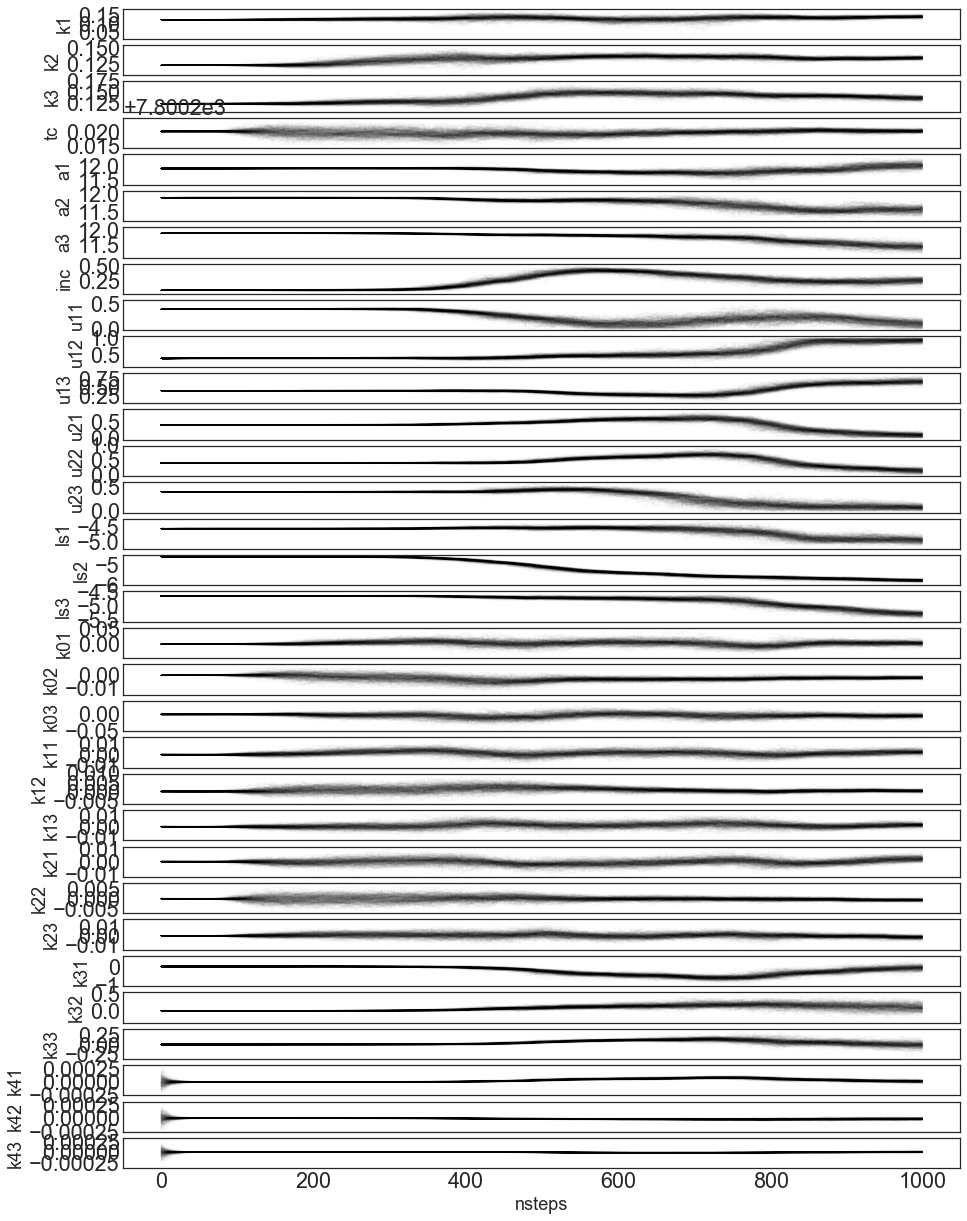

In [25]:
plt.style.use('seaborn-white')

param_names='k1,k2,k3,tc,a1,a2,a3,inc,u11,u12,u13,u21,u22,u23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

nwalkers, nsteps, ndim = chain.shape
fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
#ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
#percs = [np.percentile(sampler.chain2[:,:,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
#[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
plt.xlabel('nsteps')

# re-calculate logprob

In [26]:
burn=1000
thin=100

fc = chain2[:,burn::thin,:].reshape([-1,chain2.shape[-1]])
fc.shape

(23040, 32)

In [38]:
fc_lnprob=[logprob(th, *args) for th in tqdm(fc)]

#fc_lnp = np.load(os.path.join(loc,'best_model_long_lnp1.npy'))
#fc_lnp.shape

100%|██████████| 23040/23040 [02:09<00:00, 177.66it/s]


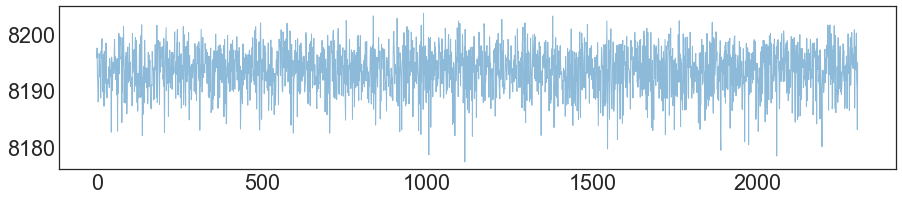

In [30]:
fig=plt.figure(figsize=(15,3))
plt.plot(fc_lnprob[::10], lw=1, alpha=0.5)

Add 50,16,84-percentiles:

## Results

Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

In [40]:
param_names='k1,k2,k3,tc,a1,a2,a3,inc,u11,u12,u13,u21,u22,u23,ls1,ls2,ls3,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')

#using full chain excluding burn-in
max_idx=np.argmax(fc_lnprob)

#posterior of parameter vector
pv=fc[max_idx,:]

for n, i in zip(param_names, pv): 
    print('{0}: {1:.4f}'.format(n,i))

k1: 0.1389
k2: 0.1346
k3: 0.1313
tc: 7800.2197
a1: 12.4852
a2: 12.2218
a3: 12.1640
inc: 1.5678
u11: 1.0183
u12: 0.5744
u13: 0.5854
u21: -0.6097
u22: 0.0760
u23: -0.1387
ls1: -6.2706
ls2: -6.3109
ls3: -6.1965
k01: -0.0010
k02: -0.0008
k03: 0.0004
k11: -0.0003
k12: 0.0001
k13: 0.0006
k21: -0.0006
k22: 0.0001
k23: 0.0001
k31: -62.9478
k32: -91.3118
k33: -63.7861
k41: 0.0081
k42: 0.0117
k43: 0.0082


In [41]:
final_theta=pv

In [42]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
df.describe()

k1          k2          k3          tc          a1          a2  \
count  23040.0000  23040.0000  23040.0000  23040.0000  23040.0000  23040.0000   
mean       0.1386      0.1346      0.1315   7800.2197     12.1820     11.9803   
std        0.0026      0.0024      0.0021      0.0001      0.2689      0.2175   
min        0.1187      0.1235      0.1220   7800.2192     10.6319     10.9554   
25%        0.1374      0.1333      0.1302   7800.2196     12.0453     11.8442   
50%        0.1389      0.1348      0.1316   7800.2197     12.2296     12.0044   
75%        0.1402      0.1362      0.1330   7800.2198     12.3680     12.1357   
max        0.1484      0.1418      0.1391   7800.2203     12.8374     12.5689   

               a3         inc         u11         u12     ...             k13  \
count  23040.0000  23040.0000  23040.0000  23040.0000     ...      23040.0000   
mean      11.9611      1.5596      0.9491      0.5045     ...          0.0009   
std        0.2309      0.0074      0.1268      0.1166     ...          0.0004   
min       10.7817      1.5304      0.4212      0.1309     ...         -0.0008   
25%       11.8224      1.5544      0.8660      0.4227     ...          0.0006   
50%       11.9868      1.5604      0.9550      0.5025     ...          0.0009   
75%       12.1275      1.5657      1.0383      0.5831     ...          0.0011   
max       12.5878      1.5708      1.3323      0.9949     ...          0.0028   

              k21         k22         k23         k31         k32         k33  \
count  23040.0000  2.3040e+04  23040.0000  23040.0000  23040.0000  23040.0000   
mean      -0.0004  1.8031e-04      0.0001    -98.1641    -88.2075    -70.6898   
std        0.0003  2.0618e-04      0.0004     33.7887      7.6958     28.2731   
min       -0.0018 -6.1123e-04     -0.0015   -236.3159   -118.4484   -181.6937   
25%       -0.0006  4.1580e-05     -0.0001   -120.8846    -93.3440    -89.7126   
50%       -0.0004  1.7853e-04      0.0001    -97.6334    -88.3035    -70.6570   
75%       -0.0002  3.1953e-04      0.0004    -75.3094    -83.2042    -51.5741   
max        0.0008  1.0670e-03      0.0017     69.7027    -58.2445     49.0640   

              k41         k42         k43  
count  23040.0000  23040.0000  23040.0000  
mean       0.0126      0.0113      0.0091  
std        0.0043      0.0010      0.0036  
min       -0.0089      0.0075     -0.0063  
25%        0.0097      0.0107      0.0066  
50%        0.0125      0.0113      0.0091  
75%        0.0155      0.0120      0.0115  
max        0.0303      0.0152      0.0233  

[8 rows x 32 columns]

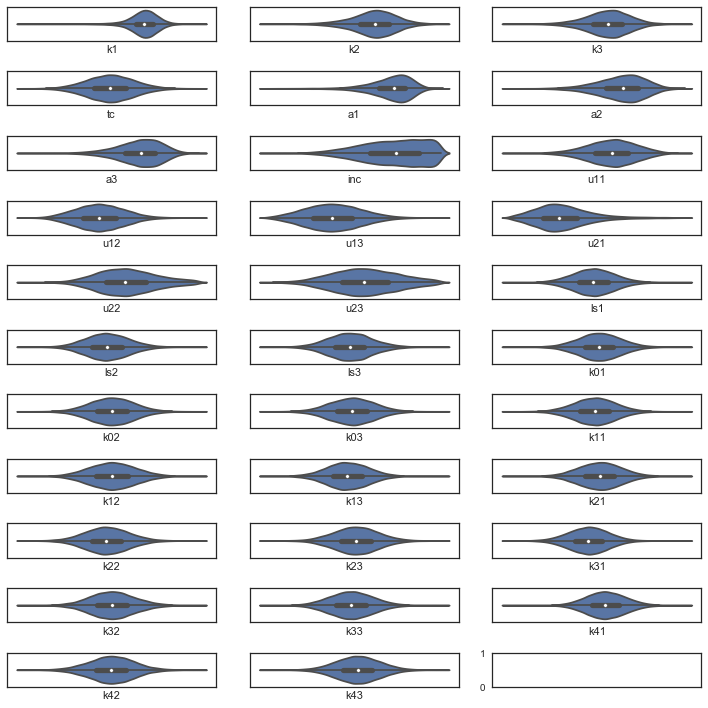

In [43]:
import seaborn as sb

with sb.axes_style('white'):
    fig, axs = plt.subplots(11,3, figsize=(10,10))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    plt.setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

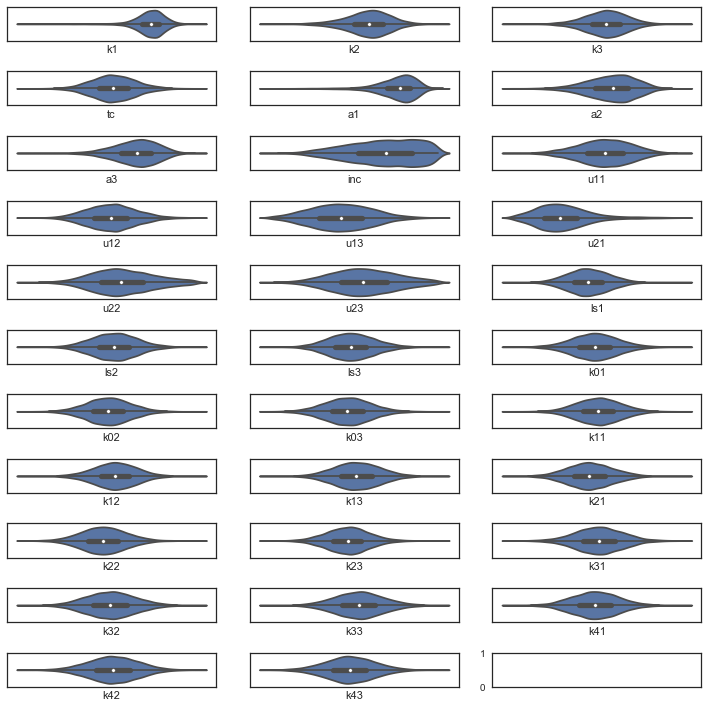

In [30]:
import seaborn as sb

with sb.axes_style('white'):
    fig, axs = plt.subplots(11,3, figsize=(10,10))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    plt.setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

## BIC

In [44]:
def compute_bic(n,k,logL):
    '''
    n: number of data points
    m: number of parameters
    L: the maximized value of the likelihood function of the model
    '''
    return np.log(n)*m-2*logL

In [45]:
col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

cols=[col1,col2,col3]

m=chain2.shape[-1]

for n,(b,t,f,fwhm,dx,dy,col) in enumerate(zip(bands,ts,fluxes,fwhms,dxs,dys,cols)):
    print(b)
    n=len(t)
    logL=loglike([pv[i] for i in col], t, f, p_, fwhm, dx, dy)
    print('loglike={}'.format(logL))
    bic=compute_bic(n,m,logL)
    print('BIC={}'.format(bic))

g
loglike=2141.5162681
BIC=-4093.28568361
r
loglike=3965.37864652
BIC=-7720.94038564
z
loglike=2098.68468776
BIC=-4007.62252293


## Sample the flatchain

In [46]:
#100 samples from the posterior for each band 
mod_sys={}
sys={}
mod={}

# theta1 = [k1,tc,a1,inc,u11,u21,ls1,k01,k11,k21,k31,k41]
# theta2 = [k2,tc,a2,inc,u12,u22,ls2,k02,k12,k22,k32,k42]
# theta3 = [k3,tc,a3,inc,u13,u23,ls3,k03,k13,k23,k33,k43]

col1=[0,3,4,7,8,11,14,17,20,23,26,29]
col2=[1,3,5,7,9,12,15,18,21,24,27,30]
col3=[2,3,6,7,10,13,16,19,22,25,28,31]

In [47]:
[param_names[i] for i in col1]

['k1',
 'tc',
 'a1',
 'inc',
 'u11',
 'u21',
 'ls1',
 'k01',
 'k11',
 'k21',
 'k31',
 'k41']

$$
\rm \frac{no \; detection - expected \; value}{1\sigma \; bin} = 2.4 \; \sigma
$$

$$
P(\theta|D)\propto P(\theta) \times P(D|\theta) 
$$

In [48]:
mod_best = {}
sys_best = {}
full_best = {}
nsamples=1000

#params varies per band
for b,t,f,fwh,xc,yc,col in zip(bands,
                             [t1,t2,t3],
                             [f1,f2,f3],
                             [fwhm1,fwhm2,fwhm3],
                             #[unc1,unc2,unc3],
                             [xcen1,xcen2,xcen3],
                             [ycen1,ycen2,ycen3],
                            [col1,col2,col3]):
    mod_sys[b]=[]
    sys[b]=[]
    mod[b]=[]
    #get 100 samples from the posterior
    for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]:
    #with replacement/ bootstrap
    #for th in [np.random.choice(fc[:,:]) for j in range(1000)]:
        '''
        th is a huge vector, get only necessary params 
        in the form of theta1,2,3 above:
        loglike(theta, t, f, p, dx, dy, dummy)
        '''
        cc=[]
        for c in col:
            cc.append(th[c])
        mod_sys[b].append(loglike(cc, t, f, p_, fwh, xc, yc, ret_full=True))
        sys[b].append(loglike(cc, t, f, p_, fwh, xc, yc, ret_sys=True))
        mod[b].append(loglike(cc, t, f, p_, fwh, xc, yc, ret_mod=True))
    #best
    vv = []
    for v in col:
            vv.append(pv[v])
    mod_best[b] = loglike(vv, t, f, p_, fwh, xc, yc, ret_mod=True)
    sys_best[b] = loglike(vv, t, f, p_, fwh, xc, yc, ret_sys=True)
    full_best[b] = loglike(vv, t, f, p_, fwh, xc, yc, ret_full=True)

check mean distribution for n samples sampled m times

### transit model

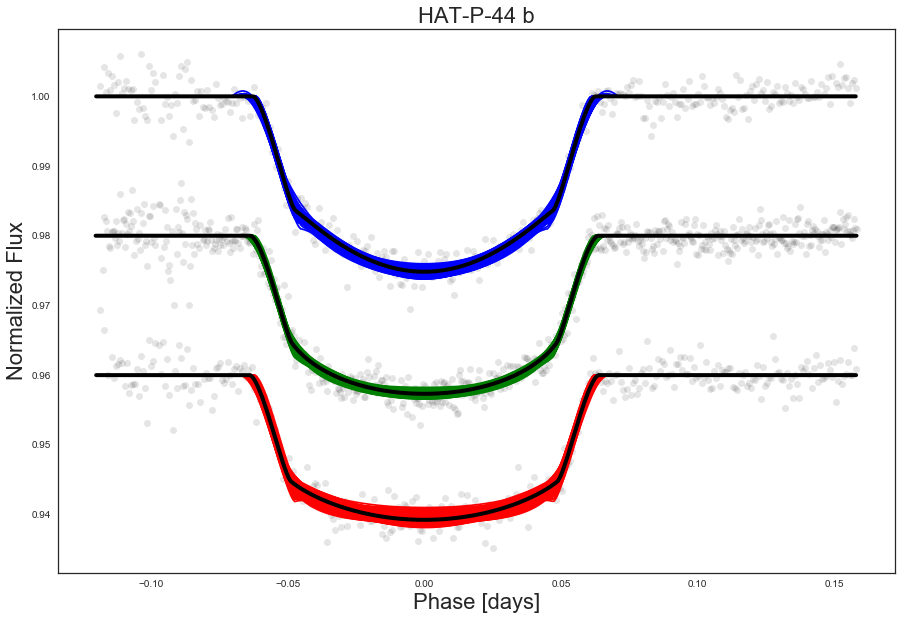

In [49]:
plt.style.use('seaborn-white')
colors='b,g,r'.split(',')
tc_hat=pv[3]
fontsize=22
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']

fig,ax=plt.subplots(1,1,figsize=(15,10))
for n,(b,c,l) in enumerate(zip(bands,colors,labels)):
    ax.plot(ts[n]-tc_hat, fluxes[n]-sys_best[b]-0.02*n, 'ko', alpha=0.1)
    for i in mod[b]:
        ax.plot(ts[n]-tc_hat, i-0.02*n,'-', color=c, label=l)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, mod_best[b]-0.02*n, 'k-', lw=4)
    #plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title('HAT-P-44 b',fontsize=fontsize)
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('Phase [days]', fontsize=fontsize)
#ax.legend(labels,loc='lower right',fontsize=fontsize)

### systematics model

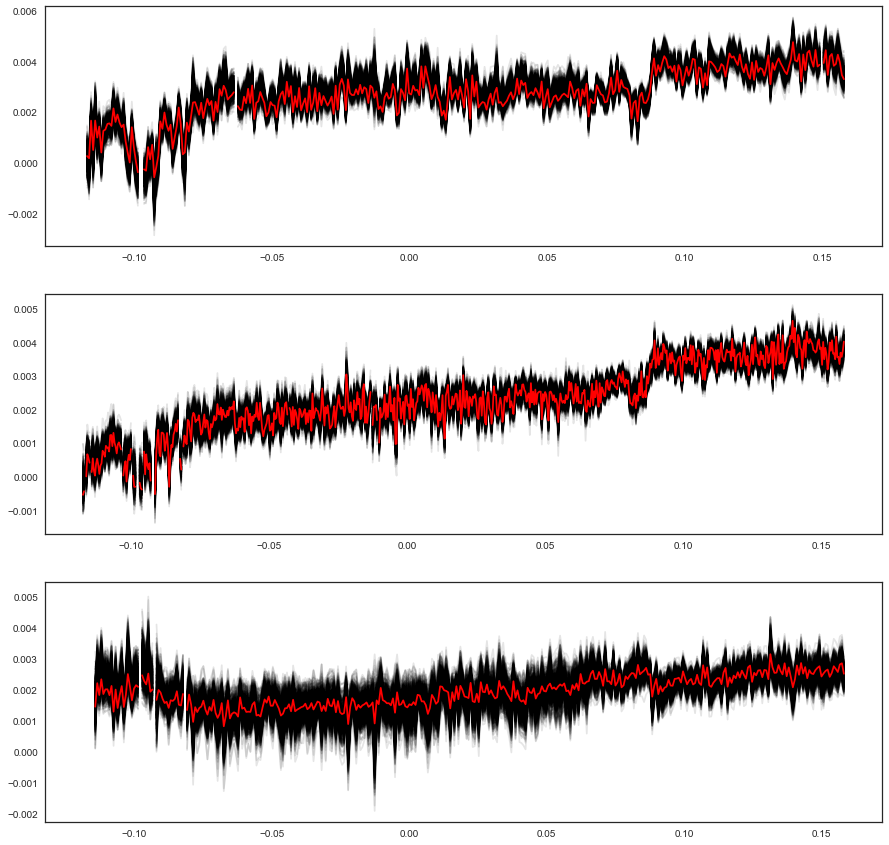

In [50]:
tc_hat=pv[3]
fig = plt.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=plt.subplot(3,1,n+1)
    for i in sys[b]:
        plt.plot(ts[n]-tc_hat, i,'k-',alpha=0.1)
    #superpose best fit
    ax.plot(ts[n]-tc_hat, sys_best[b], 'r-')

### systematics + transit

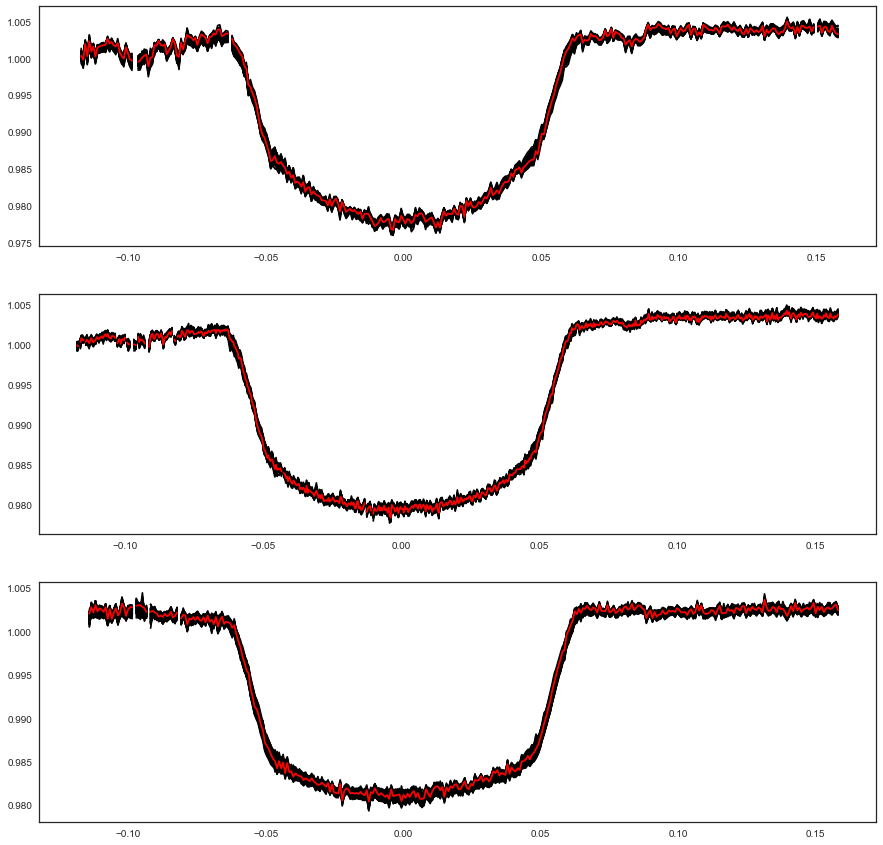

In [48]:
tc_hat=pv[3]
fig = plt.figure(figsize=(15,15))
for n,b in enumerate(bands):
    ax=plt.subplot(3,1,n+1)
    for i in mod_sys[b]:
        plt.plot(ts[n]-tc_hat, i,'k-')
    #superpose best fit
    ax.plot(ts[n]-tc_hat, full_best[b], 'r-')

## g-band

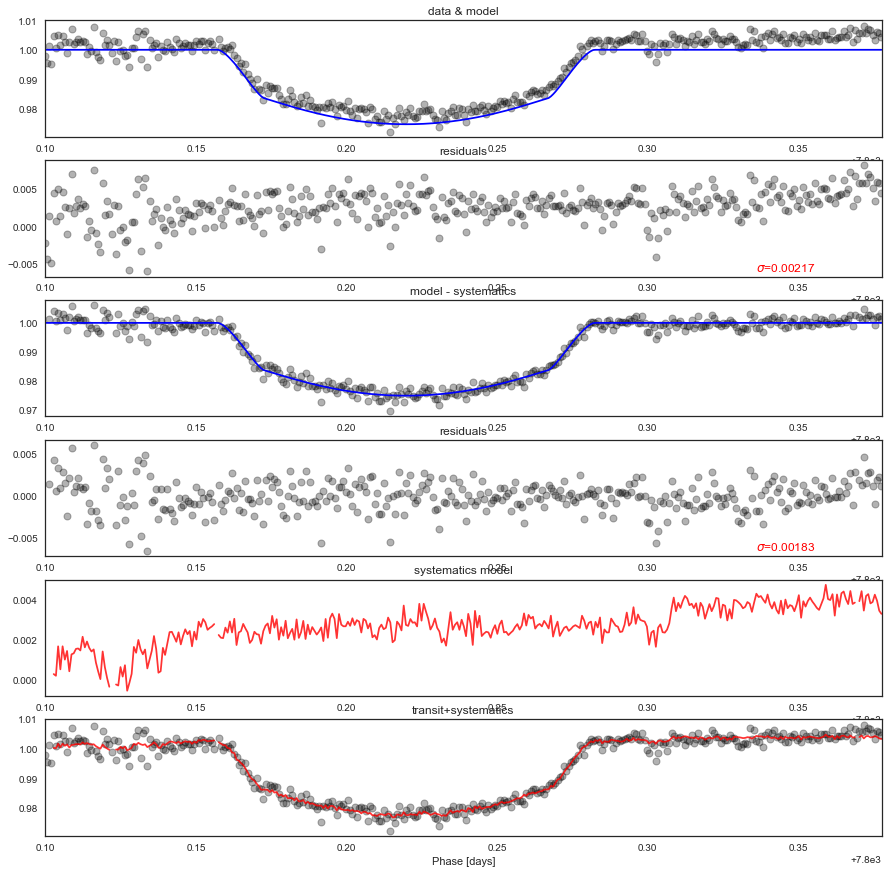

In [51]:
n=0
b='g'

plt.style.use('seaborn-white')
fig, ax = plt.subplots(6, 1, figsize=(15,15))
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'b-')
ax[0].set_title('data & model')
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals')
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'b-')
ax[2].set_title('model - systematics')
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals')
#systematics
ax[4].plot(ts[n], sys_best[b], 'r-', alpha=0.8)
ax[4].set_title('systematics model')
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'r-', alpha=0.8);
ax[5].set_title('transit+systematics')
plt.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
plt.xlabel('Phase [days]')

## r-band

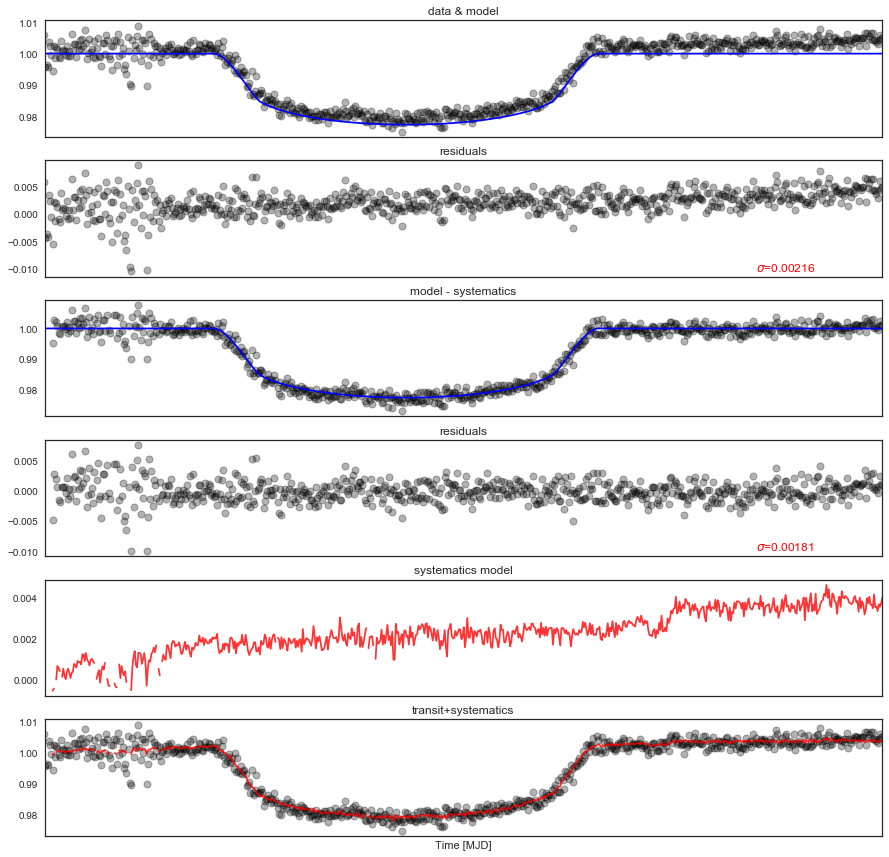

In [52]:
n=1
b='r'

plt.style.use('seaborn-white')
fig, ax = plt.subplots(6, 1, figsize=(15,15))
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'b-')
ax[0].set_title('data & model')
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals')
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'b-')
ax[2].set_title('model - systematics')
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals')
#systematics
ax[4].plot(ts[n], sys_best[b], 'r-', alpha=0.8)
ax[4].set_title('systematics model')
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'r-', alpha=0.8);
ax[5].set_title('transit+systematics')
plt.setp(ax, xticks=[], xlim=(t.min(), t.max()));
plt.xlabel('Time [MJD]')

## z-band

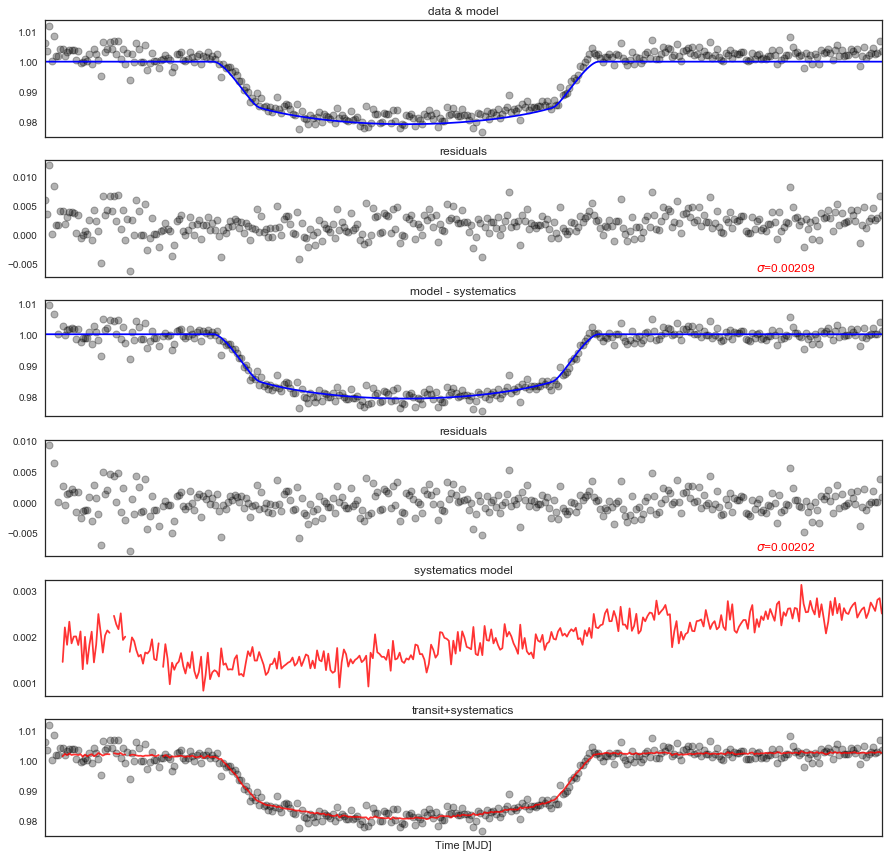

In [53]:
n=2
b='z'

plt.style.use('seaborn-white')
fig, ax = plt.subplots(6, 1, figsize=(15,15))
#uncorrected
ax[0].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(ts[n], mod_best[b], 'b-')
ax[0].set_title('data & model')
#residuals
ax[1].plot(ts[n], fluxes[n]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res1='$\sigma$={:.5f}'.format(np.std(fluxes[n]-mod_best[b]))
ax[1].text(0.85,0.05,res1,transform=ax[1].transAxes,color='r')
ax[1].set_title('residuals')
#corrected
ax[2].plot(ts[n], fluxes[n]-sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(ts[n], mod_best[b], 'b-')
ax[2].set_title('model - systematics')
#residuals
ax[3].plot(ts[n], fluxes[n]-sys_best[b]-mod_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
res2='$\sigma$={:.5f}'.format(np.std(fluxes[n]-sys_best[b]-mod_best[b]))
ax[3].text(0.85,0.05,res2,transform=ax[3].transAxes,color='r')
ax[3].set_title('residuals')
#systematics
ax[4].plot(ts[n], sys_best[b], 'r-', alpha=0.8)
ax[4].set_title('systematics model')
ax[5].plot(ts[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(ts[n], full_best[b], 'r-', alpha=0.8);
ax[5].set_title('transit+systematics')
plt.setp(ax, xticks=[], xlim=(t.min(), t.max()));
plt.xlabel('Time [MJD]')

## rms of residuals

In [54]:
def rms(x):
    return np.sqrt(np.nanmean(x**2))

In [55]:
thinning=10
for n,b in enumerate(bands):
    print(b)
    print('rms={}'.format(rms(fluxes[n]-sys_best[b]-mod_best[b])*100))

g
rms=0.182768454622
r
rms=0.181014145567
z
rms=0.202337409917


In [38]:
def binning(data, bins):
    bin_means = (np.histogram(data, bins, weights=data)[0] / np.histogram(data, bins)[0])
    return bin_means

In [39]:
def binning2(data, bins):
    digitized = np.digitize(data, bins)
    bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]
    return bin_means

In [59]:
def binning3(data, bins):
    slices = np.linspace(0, 100, bins+1, True).astype(np.int)
    counts = np.diff(slices)
    return np.add.reduceat(data, slices[:-1]) / counts

## binning
* See [stackoverflow](https://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy)

The binning must be less than t14 and/or t34. Based on the best fit model on the detrended light curve, t14 is about 0.01 to 0.02 day.

In [41]:
0.01*24*60 #minutes

14.399999999999999

Use 5 minutes binning.

```
OUT-TEMP=                   3. / Outside temperature [C]                        
OUT-HUM =                  82. / Outside humidity [%]                           
IN-TEMP =                99.99 / Inside temperature [C]                         
IN-HUM  =                  70. / Inside humidity [%]                            
WIND-SPD=                  0.5 / Wind speed [m/s]                               
WIND-DIR=                 240. / Wind direction [deg]                           
PRESSURE=                 983. / Atmospheric pressure [hPa]
```

In [57]:
from astropy.io import fits
data_dir_raw = '/home/'+getpass.getuser()+'/data/transit/hatp44_data/'
file_list2= glob.glob(data_dir_raw+'MSCL*.df.fits')
file_list2.sort()

from tqdm import tqdm

gband=[]
rband=[]
zband=[]

out_temp={}
out_humid={}
in_temp={}
in_humid={}
wind_spd={}
wind_dir={}
pressure={}

for b in bands:
    out_temp[b]=[]
    out_humid[b]=[]
    in_temp[b]=[]
    in_humid[b]=[]
    wind_spd[b]=[]
    wind_dir[b]=[]
    pressure[b]=[]

#
for i in tqdm(file_list2):
    hdr = fits.getheader(i)
    #if hdr['OBJECT']  == 'HAT-P-44':
    if hdr['FILTER'] == 'g':
        gband.append(i)
        out_temp['g'].append(hdr['OUT-TEMP'])
        out_humid['g'].append(hdr['OUT-HUM'])
        in_temp['g'].append(hdr['IN-TEMP'])
        in_humid['g'].append(hdr['IN-HUM'])
        wind_spd['g'].append(hdr['WIND-SPD'])
        wind_dir['g'].append(hdr['WIND-DIR'])
        pressure['g'].append(hdr['PRESSURE'])
    elif hdr['FILTER'] == 'r':
        rband.append(i)
        out_temp['r'].append(hdr['OUT-TEMP'])
        out_humid['r'].append(hdr['OUT-HUM'])
        in_temp['r'].append(hdr['IN-TEMP'])
        in_humid['r'].append(hdr['IN-HUM'])
        wind_spd['r'].append(hdr['WIND-SPD'])
        wind_dir['r'].append(hdr['WIND-DIR'])
        pressure['r'].append(hdr['PRESSURE'])
    elif hdr['FILTER'] == 'z_s':
        zband.append(i)
        out_temp['z'].append(hdr['OUT-TEMP'])
        out_humid['z'].append(hdr['OUT-HUM'])
        in_temp['z'].append(hdr['IN-TEMP'])
        in_humid['z'].append(hdr['IN-HUM'])
        wind_spd['z'].append(hdr['WIND-SPD'])
        wind_dir['z'].append(hdr['WIND-DIR'])
        pressure['z'].append(hdr['PRESSURE'])
    else: #redundancy
        print(i)

print('{0}\n{1}\n{2}'.format(len(gband), len(rband), len(zband)))

100%|██████████| 1456/1456 [00:06<00:00, 222.12it/s]

376
704
376


In [43]:
fits.getheader(file_list2[0])['EXP-STRT']

'14:18:14.529240'

In [44]:
fits.getheader(file_list2[-1])['EXP-STRT']

'20:58:41.311526'

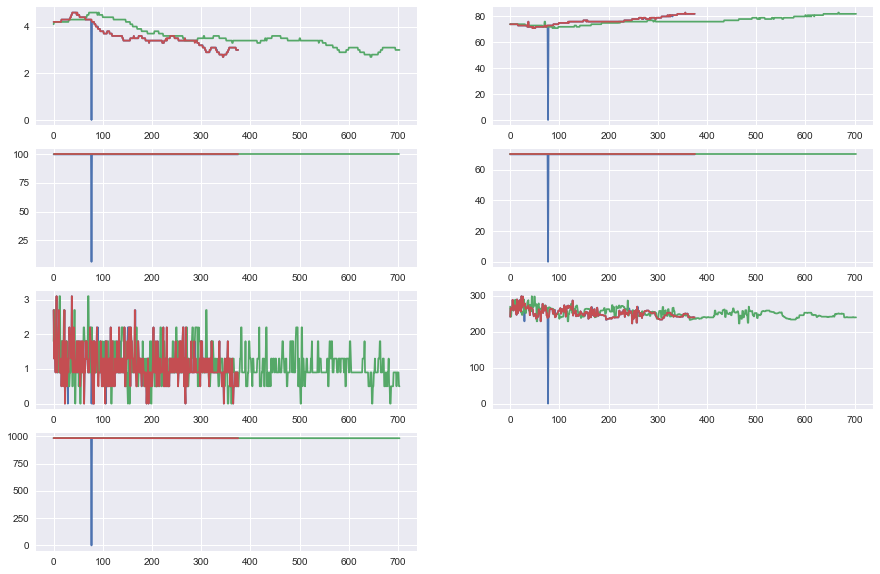

In [45]:
fig = plt.figure(figsize=(15,10))
for n, param in enumerate([out_temp, out_humid, in_temp, in_humid, wind_spd,wind_dir, pressure]):
    ax = plt.subplot(4,2,n+1)
    for n, b in enumerate(bands):
        ax.plot(param[b])

In [46]:
#total observation time
(ts[0][-1]-ts[0][0])*24

6.6713520000266726

## binning the residuals

In [60]:
width=5 # min
print('bin width={} min\n'.format(width))

n_min_binning={}
for n,(b,i) in enumerate(zip(bands,[gband, rband, zband])):
    exp=fits.getheader(i[0])['EXPTIME']
    print(b)
    print('exp time={} sec'.format(exp))
    print('total time = {} min'.format(len(ts[n])*exp/60))
    bins=np.ceil(len(ts[n])*exp/60/width)
    n_min_binning[b]=bins
    print('bins = {}'.format(bins))
    
    resid=fluxes[n]-sys_best[b]-mod_best[b]
    #slices = np.linspace(np.min(resid), np.max(resid), bins+1, True).astype(np.int)
    mean=binning3(resid.values,bins=bins)
    #print(len(mean))
    print('rms ={:.3f}'.format(rms(mean)*100)) #%

bin width=5 min

g
exp time=60.0 sec
total time = 376.0 min
bins = 76.0
rms =0.225
r
exp time=30.0 sec
total time = 352.0 min
bins = 71.0
rms =0.301
z
exp time=60.0 sec
total time = 376.0 min
bins = 76.0
rms =0.255


/home/jp/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  


Fukui-san's photometric precision achieved for HAT-P-14 (V=10):
```
g                       r                     z
RMS(10s)  = 0.10%       RMS(10s)  = 0.091%    RMS(30s) = 0.068%
RMS(5min) = 0.028%      RMS(5min) = 0.022%    RMS(5min) = 0.023%
```
$$
m_1-m_2=-2.5\log(f_1/f_2)\\
\rightarrow \frac{f_1}{f_2} = 10^{\Big(\frac{m_2-m_1}{2.5}\Big)}\\
\frac{f_1}{f_2} = 10^{\Big(\frac{13.2-10}{2.5}\Big)} = 19.9
$$
The photometric noise/ uncertainty goes with $\sqrt{\frac{f_1}{f_2}}$. Thus, the increase in the expected noise should be
$$
\sqrt{\frac{f_1}{f_2}}=4.47
$$
Currently, the rms of 0.23% for 5 minute binning, compared to Fukui-san's 0.028% is about an order of magnitude. I have to reduce this to about 5 to match the precisison achieved by Fukui-san.

In [ ]:
def binning4(data, bins):
    index = pd.date_range('1/1/2000', periods=len(fluxes[n]), freq=str(bins)+'T')
    df = pd.DataFrame(resid.values, index=index)
    return df

In [ ]:
for n,(b,bins) in enumerate(zip(bands,[76,71,76])):
    resid=fluxes[n]-sys_best[b]-mod_best[b]
    binned=binning4(resid.values, bins=bins)
    binned=df.resample('3T').mean().dropna()

In [ ]:
rms(binned.values)

## binning before model fitting

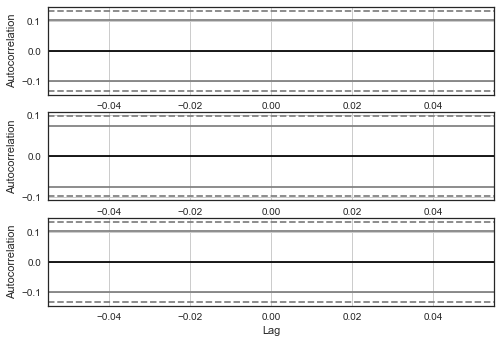

In [62]:
from pandas.plotting import autocorrelation_plot

fig = plt.figure()
for n,b in enumerate(bands):
    ax=plt.subplot(3,1,n+1)
    autocorrelation_plot(fluxes[n]-sys_best[b]-mod_best[b], ax=ax)
    #autocorrelation_plot(sys_best[b]-mod_best[b], ax=ax)

correlation: u1, u2; k1, k3; i, a

In [63]:
n,b=0,'g'

d1 = {'g_flux': fluxes[n], 'g_mod': mod_best[b], 'g_sys':sys_best[b], 'g_full': full_best[b], 'g(f-sys)': fluxes[n]-sys_best[b]}
df1=pd.DataFrame(data=d1, index=ts[n])

n,b=1,'r'
d2 = {'r_flux': fluxes[n], 'r_mod': mod_best[b], 'r_sys':sys_best[b], 'r_full': full_best[b], 'r(f-sys)': fluxes[n]-sys_best[b]}
df2=pd.DataFrame(data=d2, index=ts[n])


n,b=2,'z'
d3 = {'z_flux': fluxes[n], 'z_mod': mod_best[b], 'z_sys':sys_best[b], 'z_full': full_best[b], 'z(f-sys)': fluxes[n]-sys_best[b]}
df3=pd.DataFrame(data=d3, index=ts[n])

frames = [df1, df2, df3]

final_df = pd.concat(frames)
final_df.tail()

g(f-sys)  g_flux  g_full  g_mod  g_sys  r(f-sys)  r_flux  \
BJD(TDB)-2450000                                                             
7800.3748              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3756              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3763              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3771              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3778              NaN     NaN     NaN    NaN    NaN       NaN     NaN   

                  r_full  r_mod  r_sys  z(f-sys)  z_flux  z_full  z_mod  \
BJD(TDB)-2450000                                                          
7800.3748            NaN    NaN    NaN    1.0019  1.0046  1.0027    1.0   
7800.3756            NaN    NaN    NaN    1.0001  1.0026  1.0026    1.0   
7800.3763            NaN    NaN    NaN    1.0001  1.0029  1.0028    1.0   
7800.3771            NaN    NaN    NaN    1.0039  1.0067  1.0028    1.0   
7800.3778            NaN    NaN    NaN    1.0009  1.0034  1.0025    1.0   

                   z_sys  
BJD(TDB)-2450000          
7800.3748         0.0027  
7800.3756         0.0026  
7800.3763         0.0028  
7800.3771         0.0028  
7800.3778         0.0025

## Save

In [64]:
final_df.to_csv('final_grz_simultaneous.csv')

In [65]:
np.save('theta_post.csv',final_theta)

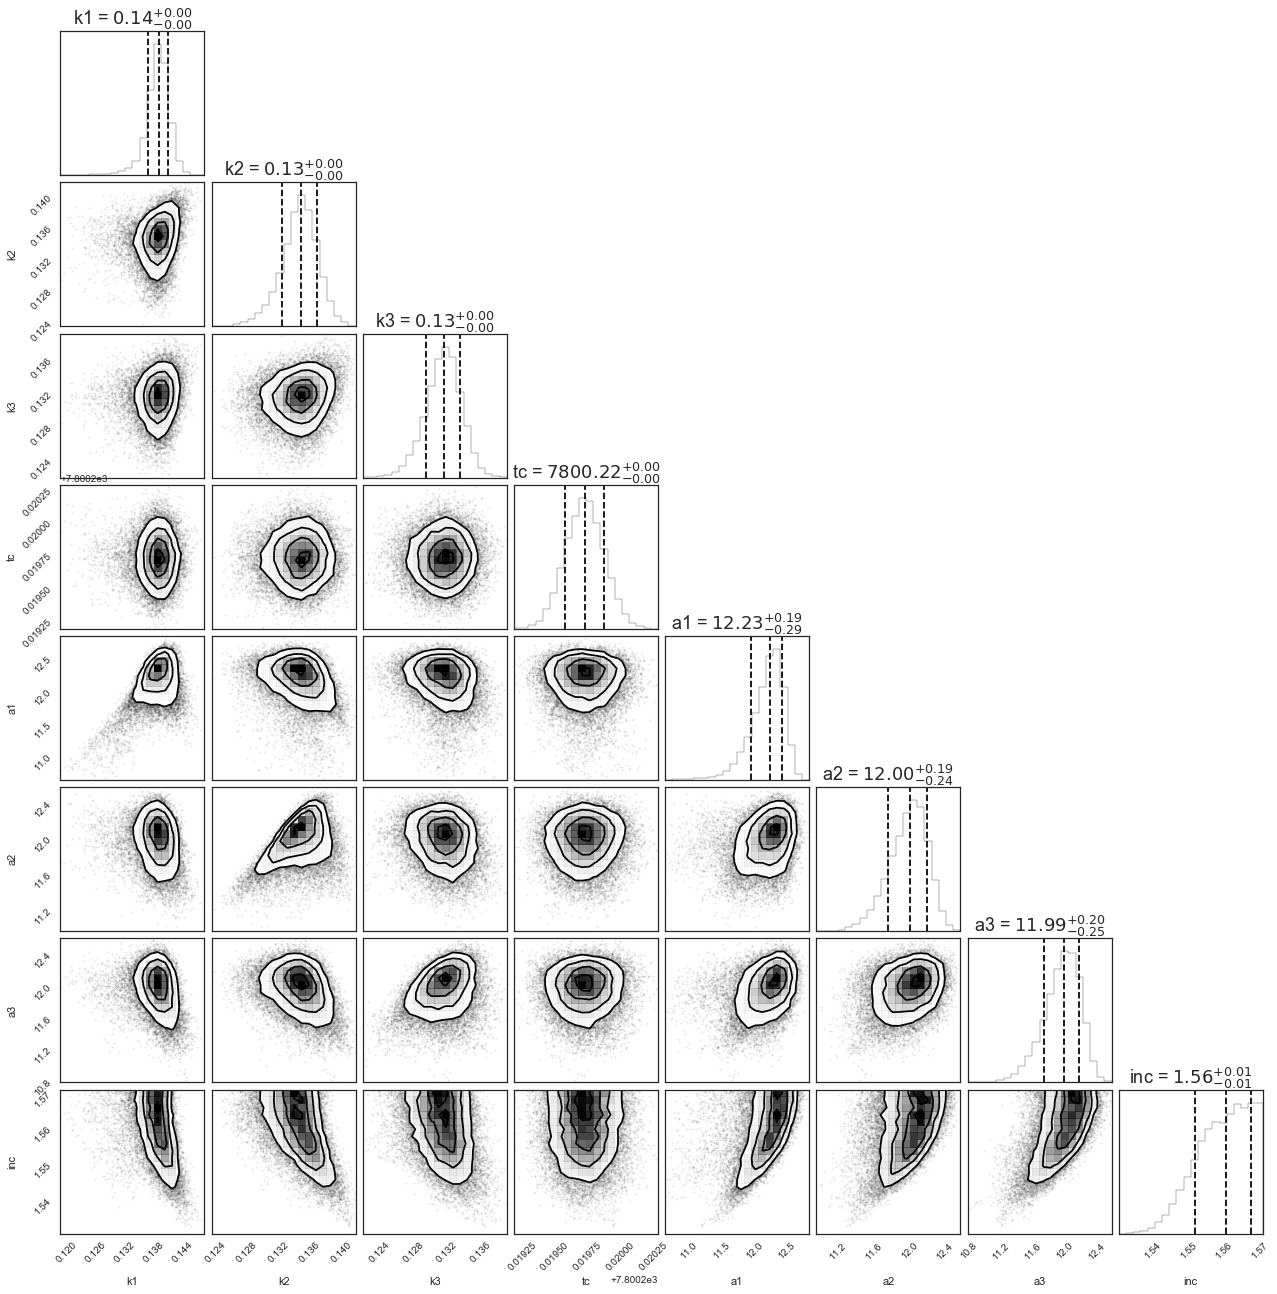

In [66]:
import corner


corner.corner(fc[:,:8], labels=param_names[:8], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

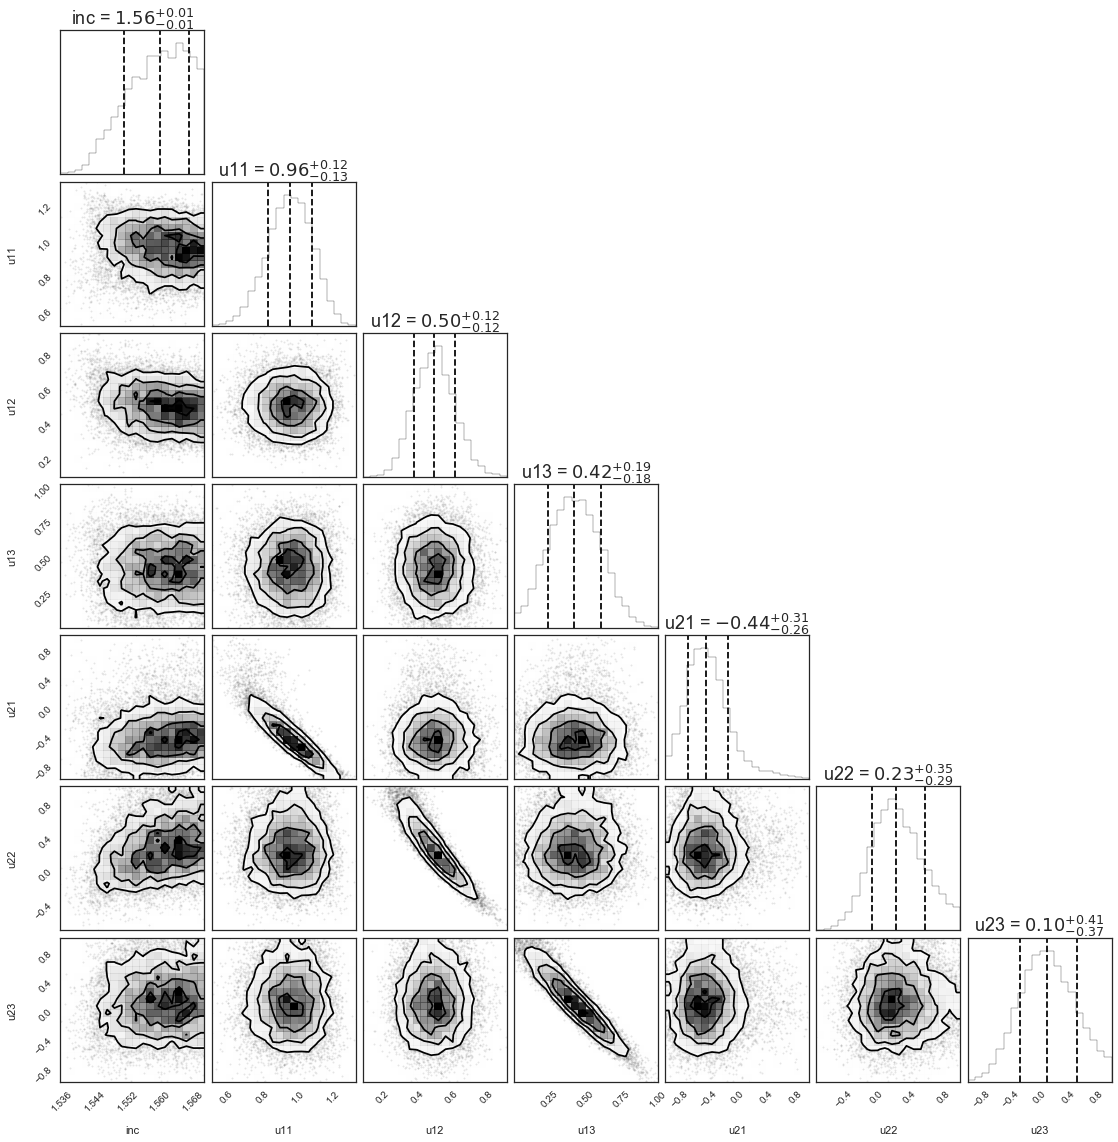

In [63]:
corner.corner(fc[:,7:14], labels=param_names[7:14], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

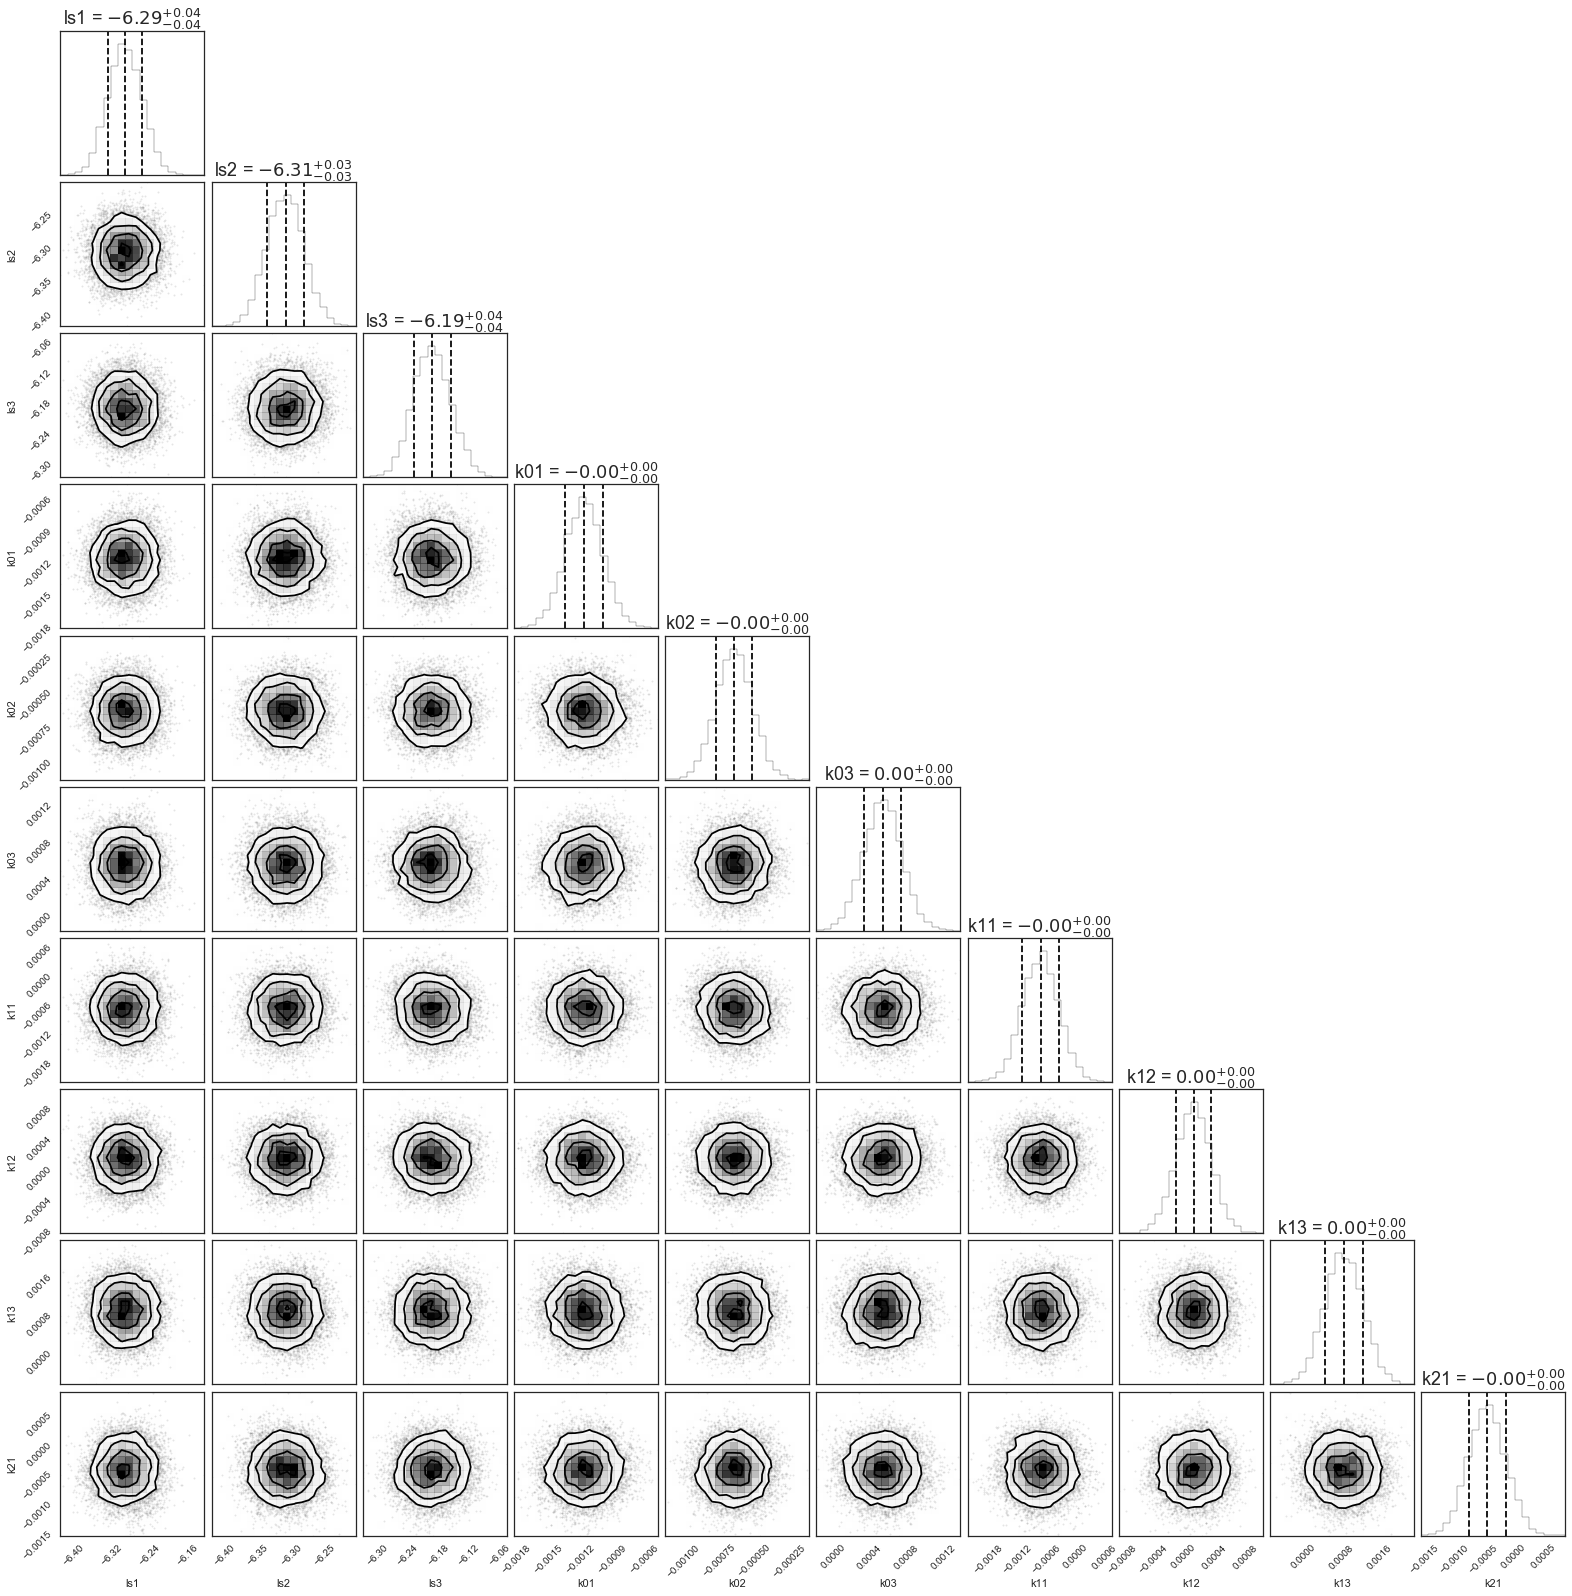

In [64]:
corner.corner(fc[:,14:24], labels=param_names[14:24], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

## even sampling of time (index)

Add evenly sampled time to compensate for sparse data (resulting to edgy/not smooth model fits especially in limb-darkening areas.

### Reevaluate model using new evenly-sampled time

## best fit with uncertainties: credible intervals

In [67]:
print('sigma:')
for i,(j,p) in enumerate(zip(pv,param_names)):
    fc_sample=fc[np.random.randint(0, fc.shape[0], size=1000)]
    sig=np.std(fc_sample[:,i])
    print('{0}={1:.4f}\t+- {2:.4f}'.format(p,j,sig))

sigma:
k1=0.1389	+- 0.0026
k2=0.1346	+- 0.0023
k3=0.1313	+- 0.0022
tc=7800.2197	+- 0.0002
a1=12.4852	+- 0.2629
a2=12.2218	+- 0.2215
a3=12.1640	+- 0.2275
inc=1.5678	+- 0.0077
u11=1.0183	+- 0.1251
u12=0.5744	+- 0.1177
u13=0.5854	+- 0.1749
u21=-0.6097	+- 0.3089
u22=0.0760	+- 0.3155
u23=-0.1387	+- 0.3723
ls1=-6.2706	+- 0.0391
ls2=-6.3109	+- 0.0284
ls3=-6.1965	+- 0.0381
k01=-0.0010	+- 0.0002
k02=-0.0008	+- 0.0001
k03=0.0004	+- 0.0002
k11=-0.0003	+- 0.0004
k12=0.0001	+- 0.0002
k13=0.0006	+- 0.0004
k21=-0.0006	+- 0.0003
k22=0.0001	+- 0.0002
k23=0.0001	+- 0.0004
k31=-62.9478	+- 33.1658
k32=-91.3118	+- 7.6182
k33=-63.7861	+- 28.2897
k41=0.0081	+- 0.0043
k42=0.0117	+- 0.0010
k43=0.0082	+- 0.0037


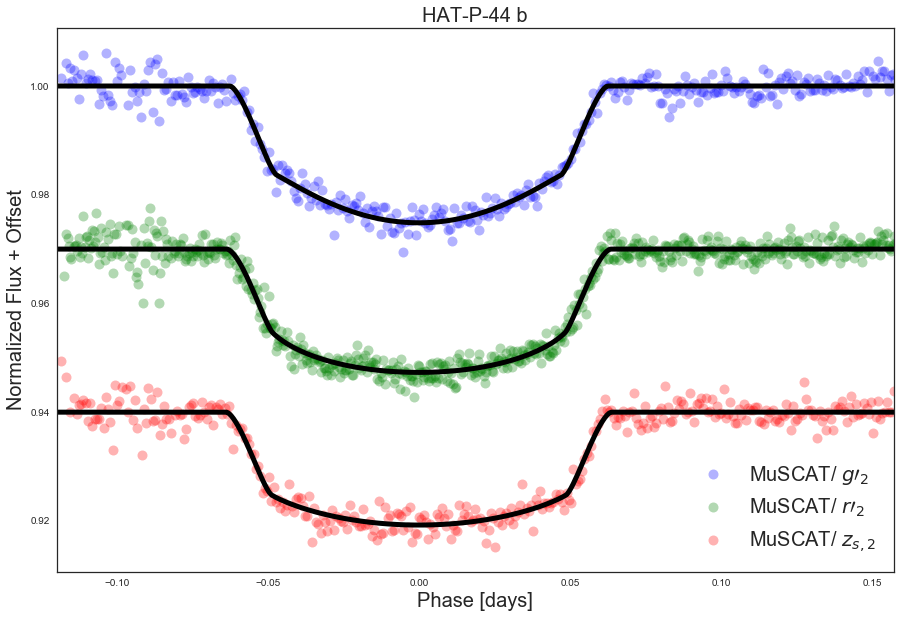

In [68]:
import matplotlib 
# # #matplotlib.rcParams.keys()
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 5})
fontsize=20

final_df=pd.read_csv('final_grz_simultaneous.csv', parse_dates=True, index_col=0)

tc=7800.219878
final_df.index=final_df.index-tc
fig,ax=plt.subplots(1,1,figsize=(15,10))
cols='g(f-sys),r(f-sys),z(f-sys)'.split(',')
colors=['b','g','r']
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']
clipped = 1
offset=0.03
for i,(col,c,l) in enumerate(zip(cols,colors,labels)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(
                marker='.', ms=20,
                alpha=0.3, linestyle='', linewidth=100,color=c, ax=ax,
                label=l)

cols2='g_mod,r_mod,z_mod'.split(',')
for i,(col,c) in enumerate(zip(cols2,colors)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(ax=ax, 
                                                    linewidth=5, color='k')
    
ax.set_xlabel('Phase [days]', fontsize=fontsize)
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
#ax.set_ylim(0.8,1)
ax.set_title('HAT-P-44 b', fontsize=fontsize)
ax.legend(labels,loc='lower right', fontsize=fontsize)

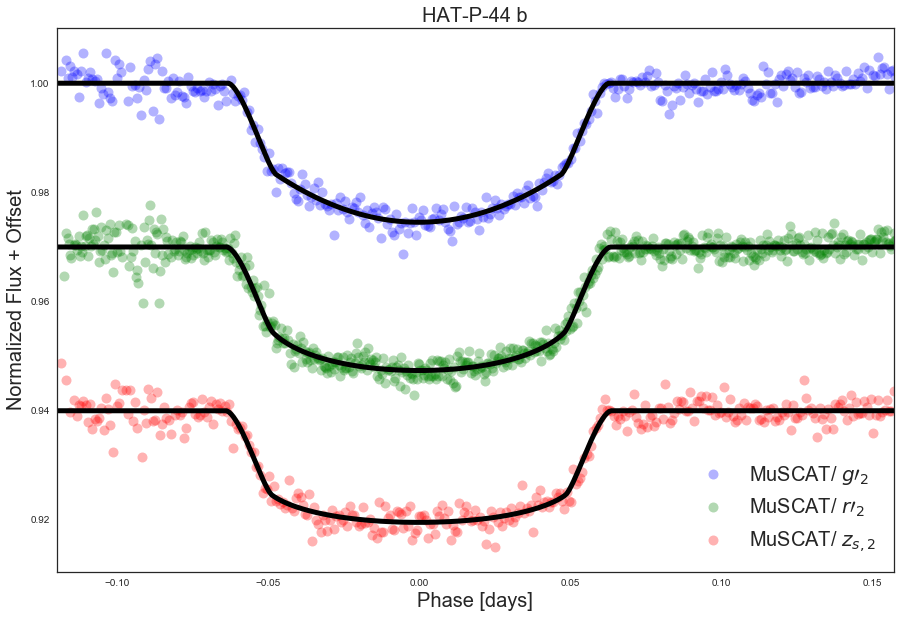

In [66]:
import matplotlib 
# # #matplotlib.rcParams.keys()
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 5})
fontsize=20

final_df=pd.read_csv('final_grz_simultaneous.csv', parse_dates=True, index_col=0)

tc=7800.219878
final_df.index=final_df.index-tc
fig,ax=plt.subplots(1,1,figsize=(15,10))
cols='g(f-sys),r(f-sys),z(f-sys)'.split(',')
colors=['b','g','r']
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']
clipped = 1
offset=0.03
for i,(col,c,l) in enumerate(zip(cols,colors,labels)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(
                marker='.', ms=20,
                alpha=0.3, linestyle='', linewidth=100,color=c, ax=ax,
                label=l)

cols2='g_mod,r_mod,z_mod'.split(',')
for i,(col,c) in enumerate(zip(cols2,colors)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(ax=ax, 
                                                    linewidth=5, color='k')
    
ax.set_xlabel('Phase [days]', fontsize=fontsize)
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
#ax.set_ylim(0.8,1)
ax.set_title('HAT-P-44 b', fontsize=fontsize)
ax.legend(labels,loc='lower right', fontsize=fontsize)

## Best fit models and (binned) residuals
* binning3 function is not implemented because of NaNs; df.resample is better because it takes into account the actual time and not only the separation between data points (e.g. two consecutive data points might be NaN and it can be problematic after binning). 
* See `width` to check binning width in min

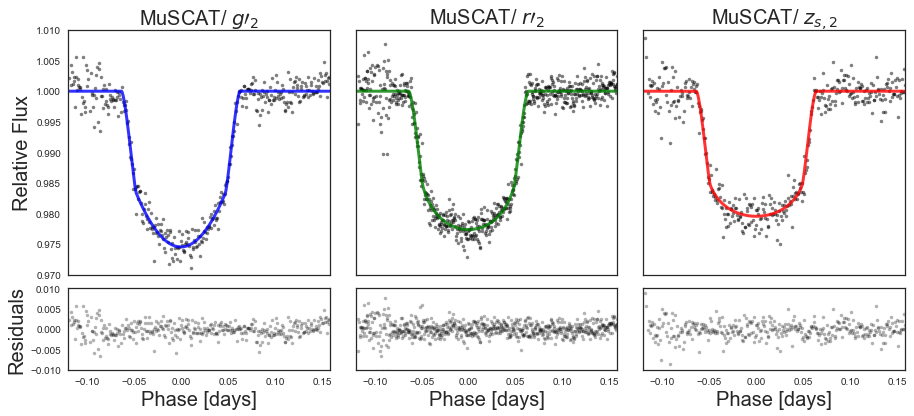

In [68]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 3})
from scipy import stats

final_df=pd.read_csv('final_grz_simultaneous.csv', parse_dates=True, index_col=0)
#final_df = df.set_index(pd.to_datetime(df.index, unit='D', origin=offset))

from matplotlib import gridspec

fig = plt.figure(figsize=(15,8))

gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1, 1, 1],
                       height_ratios=[3, 1, 1],
                       wspace=0.1, 
                       hspace=0.1
                       )
clip=False
binn=False
clipped=20
binning='3T'
ylims= [0.97,1.01]
ylims2= [-0.01,0.01]

tc=7800.219878
final_df.index=final_df.index-tc

ax1 = plt.subplot(gs[0])
if clip==True:
    final_df.iloc[:-clipped]['g(f-sys)'].plot(marker='.',alpha=0.5, 
                                            linestyle='', color='k', ax=ax1)
elif binn==True:
    final_df['g(f-sys)'].resample(binning).mean().plot(marker='.', 
                                alpha=0.1, linestyle='-', color=colors[0], ax=ax1)
else:
    final_df['g(f-sys)'].plot(marker='.', 
                                alpha=0.5, linestyle='', color='k', ax=ax1)
final_df['g_mod'].plot(linestyle='-',alpha=0.8, color=colors[0], ax=ax1)

ax1.set_ylim(ylims)
ax1.set_title(r'MuSCAT/ $g\prime_2$',fontsize=fontsize)
ax1.set_xticklabels([])
ax1.set_ylabel('Relative Flux',fontsize=fontsize)
ax1.set_xlabel('')

ax2 = plt.subplot(gs[1])

if clip==True:
    final_df.iloc[:-clipped]['r(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[1], ax=ax2)
elif binn==True:
    final_df['r(f-sys)'].resample(binning).mean().plot(
        marker='.', alpha=0.1, linestyle='-', color=colors[1], ax=ax2)
else:
    final_df['r(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax2)
final_df['r_mod'].plot(alpha=0.8, linestyle='-', color=colors[1], ax=ax2)

ax2.set_ylim(ylims)
ax2.set_title(r'MuSCAT/ $r\prime_2$',fontsize=fontsize)
#ax2.axis()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('')

ax3 = plt.subplot(gs[2])

if clip==True: #dropna, clip
    final_df.iloc[:-clipped]['z(f-sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[2], ax=ax3)
elif binn==True: #bin
    final_df['z(f-sys)'].resample(binning).mean().plot(
        marker='.', ls='', alpha=0.1, linestyle='-', color=colors[2], ax=ax3)
else:
    final_df['z(f-sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax3)
final_df['z_mod'].plot(linestyle='-', alpha=0.8, color=colors[2], ax=ax3)
    
ax3.set_ylim(ylims)
ax3.set_title(r'MuSCAT/ $z_{s,2}$',fontsize=fontsize)
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.set_yticklabels([])

ax4 = plt.subplot(gs[3])
diff_g=final_df['g(f-sys)']-final_df['g_mod']
diff_g.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax4)
#diff_g.resample(binning).mean().plot(marker='.', ax=ax4)

# t_bin=binning3(ts[0],bins=n_min_binning['g'])
# res_bin=binning3(diff_g.values,bins=n_min_binning['g'])
# ax4.plot(t_bin,res_bin,'bo')
ax4.set_ylabel('Residuals',fontsize=fontsize)
ax4.set_ylim(ylims2)
#ax4.set_xticklabels([])
ax4.set_xlabel('Phase [days]',fontsize=fontsize)

ax5 = plt.subplot(gs[4])
diff_r=final_df['r(f-sys)']-final_df['r_mod']
diff_r.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax5)
#diff_r.resample(binning).mean().plot(marker='.', ax=ax5)

# t_bin=binning3(ts[1],bins=n_min_binning['r'])
# res_bin=binning3(diff_r.values,bins=n_min_binning['r'])
# ax5.plot(t_bin,res_bin,'go')
ax5.set_ylim(ylims2)
#ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.set_xlabel('Phase [days]',fontsize=fontsize)

ax6 = plt.subplot(gs[5])
diff_z=final_df['z(f-sys)']-final_df['z_mod']
diff_z.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax6)
#fit
slope, intercept, r_value, p_value, std_err = stats.linregress(diff_z.index-tc,diff_z)
y=slope*diff_z.index-tc+intercept
ax6.plot(diff_z.index,y,alpha=0.8, linestyle='-', color=colors[2])
#diff_z.resample(binning).mean().plot(marker='.', ax=ax6)

# t_bin=binning3(ts[2],bins=n_min_binning['z'])
# res_bin=binning3(diff_z.values,bins=n_min_binning['z'])
# ax6.plot(t_bin,res_bin,'bo')
ax6.set_ylim(ylims2)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.set_xlabel('Phase [days]',fontsize=fontsize)

## Comparison of k

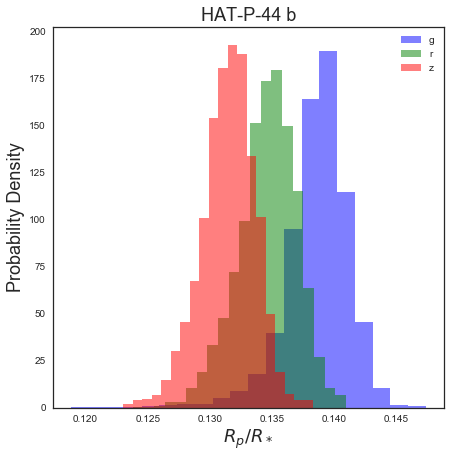

In [69]:
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

k_samples=[]
fig, ax = plt.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,n]
    ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('HAT-P-44 b',fontsize=18)

In [70]:
sigma_g_minus,sigma_g_mean,sigma_g_plus= np.percentile(k_samples[0],[15.9,50,84.1])
sigma_z_minus,sigma_z_mean,sigma_z_plus= np.percentile(k_samples[2],[15.9,50,84.1])
#diff=sigma_g_mean-sigma_z_mean
diff=sigma_g_minus-sigma_z_plus

sig=np.sqrt(sigma_z_plus**2+sigma_g_minus**2)
print('sigma_rss={}'.format(sig))
print('diff={}'.format(diff))
print('sigma={}'.format(diff/sig))

sigma_rss=0.191052134265
diff=0.00298286613939
sigma=0.0156128386153


In [174]:
(sigma_g_plus-sigma_z_minus)/np.mean([np.std(k_samples[0]),np.std(k_samples[2])])

4.5497696985531562

![scores](https://upload.wikimedia.org/wikipedia/commons/b/bb/Normal_distribution_and_scales.gif)

# Welch's t-test
This is a two-sided test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have different variances by default.

In [130]:
from scipy.stats import ttest_ind

tstat,pval=stats.ttest_ind(k_samples[0], k_samples[2], equal_var=False)
print pval

0.0


## KS test
### 1 sample

In [131]:
from scipy.stats import kstest #1 sample compared to normal
from scipy.stats import ks_2samp #2 samples

In [132]:
kstest(k_samples[0], 'norm')

KstestResult(statistic=0.54243671249899794, pvalue=0.0)

If the K-S statistic is small or the p-value is high, then we cannot reject the null hypothesis that the distribution is not normal.

### 2 samples
This is a two-sided test for the null hypothesis that 2 independent samples
are drawn from the same continuous distribution.

If the K-S statistic is small or the p-value is high, then we cannot
reject the null hypothesis that the distributions of the two samples
are the same.

In [75]:
ks_2samp(k_samples[0],k_samples[2])

Ks_2sampResult(statistic=0.884765625, pvalue=0.0)

For an different distributions, we can reject the null hypothesis since
the p-value is 0%.

[Distribution of the differnece between two means](http://www.kean.edu/~fosborne/bstat/05b2means.html)

In [76]:
from scipy.stats import mode

for i in range(3):
    print(np.mean(k_samples[i]),np.median(k_samples[i]), np.std(k_samples[i]))

(0.13855138591049873, 0.13892677808605669, 0.0028040329847571484)
(0.1345633443421666, 0.13474094154411359, 0.0023291046115012063)
(0.1315845015263884, 0.13170026214078703, 0.0021816010427272662)


In [77]:
mean1=np.mean(k_samples[0])
var1=np.std(k_samples[0])**2
mean2=np.mean(k_samples[2])
var2=np.std(k_samples[2])**2

n=len(k_samples[0])
z=(mean1-mean2)/np.sqrt((var1/n+var2/n))
z

62.751594786938618

In units of Jupiter radius

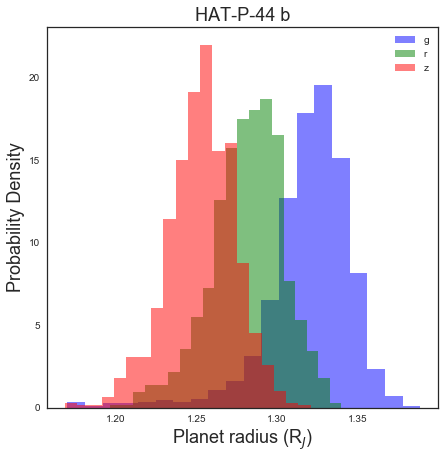

In [79]:
from astropy import units as u

import matplotlib
matplotlib.rcParams.update({'font.size': 18})

Rs=0.979

k_samples=[]
fig, ax = plt.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,n]
    factor=Rs*u.solRad.to(u.jupiterRad)
    ax.hist(sampled*factor,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'Planet radius (R$_J$)',fontsize=18)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('HAT-P-44 b',fontsize=18)

## transmission spectrum

* See also procedure of [Nikolov+2016](https://arxiv.org/pdf/1610.01186.pdf)

In [71]:
for n in range(3):
    print(np.percentile(fc[::10,n],[50,16,84]))

[ 0.13891518  0.13658028  0.1408662 ]
[ 0.13477073  0.13234794  0.13693059]
[ 0.1316159   0.12942312  0.13359101]


In [72]:
pv[:3]

array([ 0.13888504,  0.13456817,  0.13132263])

* blue (g'2 : 400-550nm)
* red (r'2 : 550-700nm)
* NIR (zs,2 : 820-920nm)
* rp/rs=0.1343 (i-band)

slope=-0.000018


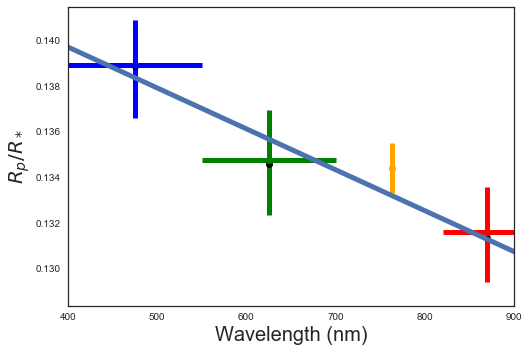

In [82]:
from scipy.stats import linregress as lg
plt.style.use('seaborn-white')

xs1=[400,550,820] #lower bandwidth
xs2=[550,700,920] #upper bandwidth
xmean=np.mean([xs1,xs2],axis=0)

Rs=0.979

ys=[]
new_axis=[]

colors='b,g,r'.split(',')
fig,ax=plt.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c)    
    new_axis.append(y*Rs)
    
#add i-band measurement
ax.errorbar(763,0.1344,yerr=0.0011,fmt='o',color='orange')

#Na absorption line
#ax.axvline(x=590, ymin=0,ymax=1, linestyle='--', color='k')
#K absorption line
#ax.axvline(x=770, ymin=0,ymax=1, linestyle='--', color='k')


# ax2 = ax.twinx() # now, ax2 is responsible for "top" axis and "right" axis
# ax2.set_xticks(new_axis)
# ax2.set_xlabel('R_p (R_${Jup}$)')

ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept)
ax.set_xlim(400,900)
print('slope={:.6f}'.format(slope))

slope=-0.000018


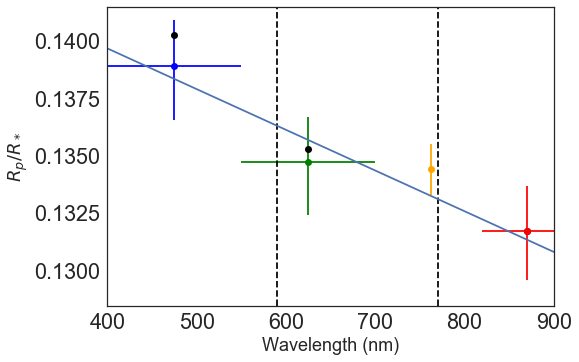

In [66]:
from scipy.stats import linregress as lg
plt.style.use('seaborn-white')

xs1=[400,550,820] #lower bandwidth
xs2=[550,700,920] #upper bandwidth
xmean=np.mean([xs1,xs2],axis=0)

Rs=0.979

ys=[]
new_axis=[]

colors='b,g,r'.split(',')
fig,ax=plt.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c)    
    new_axis.append(y*Rs)
    
#add i-band measurement
ax.errorbar(763,0.1344,yerr=0.0011,fmt='o',color='orange')

#Na absorption line
ax.axvline(x=590, ymin=0,ymax=1, linestyle='--', color='k')
#K absorption line
ax.axvline(x=770, ymin=0,ymax=1, linestyle='--', color='k')


# ax2 = ax.twinx() # now, ax2 is responsible for "top" axis and "right" axis
# ax2.set_xticks(new_axis)
# ax2.set_xlabel('R_p (R_${Jup}$)')

ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept)
ax.set_xlim(400,900)
print('slope={:.6f}'.format(slope))

In [74]:
d=pd.DataFrame({'wav':xmean, 'k':ys})

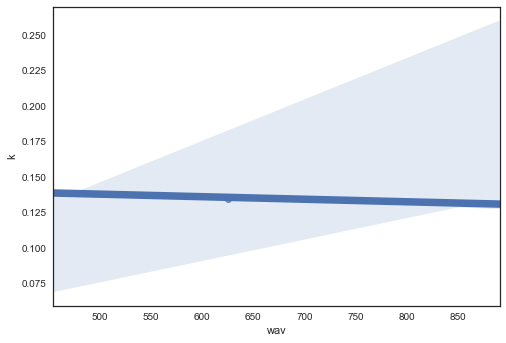

In [75]:
import seaborn as sb

sb.linearmodels.regplot(x='wav',y='k',data=d)

In [76]:
from scipy import stats

def confband(xdelta, ydelta, m, b, conf=0.95): #confidence band
    alpha = 1 - conf
    n = xdelta.size
    dof = n - 2
    x = np.linspace(xdelta.min(), xdelta.max(), 100)
    y_hat = m * xdelta + b
    y = m * x + b
    sd = np.std(ydelta - y_hat)
    sxd = np.sum((xdelta - xdelta.mean()) ** 2)
    sx = (x - xdelta.mean()) ** 2
    q = stats.t.ppf(1 - alpha/2., dof) #quantile corresponding to the lower tail= 97.5
    dy = q * sd * np.sqrt(1./n + sx/sxd)
    ucb = y + dy
    lcb = y - dy
    return lcb, ucb, x

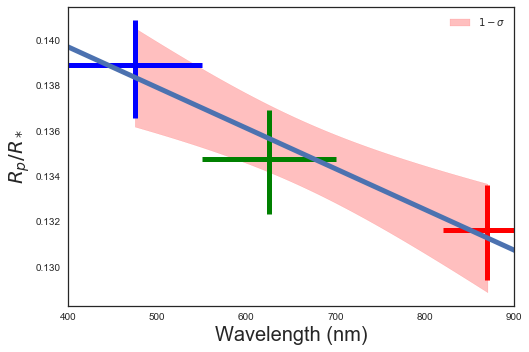

In [77]:
fig,ax=plt.subplots(1,1)
colors='b,g,r'.split(',')
ys=[]
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c)    
    #new_axis.append(y*Rs)

hatp44_slope,hatp44_intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,hatp44_slope*np.array(wavelengths)+hatp44_intercept)

#plt.plot(xdata, y_hat, 'r-', label='$\hat{y}$')
lcb, ucb, x = confband(xmean, ys, hatp44_slope, hatp44_intercept, conf=0.841) #xdelta, ydelta, m, b
ax.fill_between(x, lcb, ucb, alpha=0.25, color='r', label='$1-\sigma$');
ax.set_xlim(400, 900)
ax.legend(loc=1)
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

```
counts normalized to form a probability density, i.e.,
``n/(len(x)`dbin)``, i.e., the integral of the histogram will sum
to 1
```

In [78]:
slopes=[]
intercepts=[]
nsamples=1000

s1=k_samples[0][np.random.randint(0, k_samples[0].shape[0], size=nsamples)]
s2=k_samples[1][np.random.randint(0, k_samples[1].shape[0], size=nsamples)]
s3=k_samples[2][np.random.randint(0, k_samples[2].shape[0], size=nsamples)]

for ss1,ss2,ss3 in zip(s1,s2,s3): 
    slope,intercept,_,_,_=lg(xmean,[ss1,ss2,ss3])
    slopes.append(slope)
    intercepts.append(intercept)

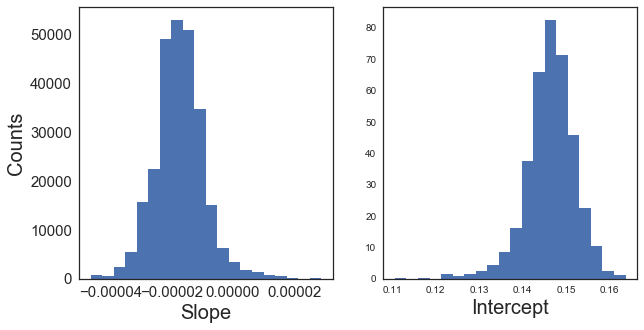

In [79]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].hist(slopes,bins=20,normed=True);
ax[0].set_ylabel('Counts',fontsize=fontsize)
ax[0].set_xlabel('Slope',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].hist(intercepts,bins=20,normed=True);
ax[1].set_xlabel('Intercept',fontsize=fontsize)

From the posterior distribution of radius ratios, we took 1000 random samples each and computed the slope of the transmission spectrum (positioned at the center of the broadband filters). The histogram of the slope is shown in Fig. X consistent with negative values with 2.3 sigma.

## significance of detection

In [80]:
x1,x2,x3=np.percentile(slopes,[50,15.9,84.1])
sig_plus=x3-x1
print((0-x1)/sig_plus)

2.44835509826


slope=-0.000018


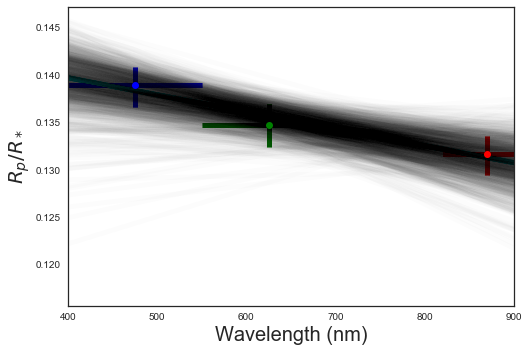

In [81]:
from scipy.stats import linregress as lg
plt.style.use('seaborn-white')

xs1=[400,550,820]
xs2=[550,700,920]
xmean=np.mean([xs1,xs2],axis=0)
Rs=0.979
ys=[]

fig,ax=plt.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'c-')

#slopes and intercepts from the posterior
for slop,interc in zip(slopes,intercepts):
    ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)
ax.set_xlim(400,900)

for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

print('slope={:.6f}'.format(slope))

In [140]:
(pv[0]-pv[1])*Rs

0.0019623997432690094

In [ ]:
from scipy.stats import linregress as lg
plt.style.use('seaborn-white')

xs1=[400,550,820]
xs2=[550,700,920]
xmean=np.mean([xs1,xs2],axis=0)
Rs=0.979
ys=[]

fig,ax=plt.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'c-')

#slopes and intercepts from the posterior
for slop,interc in zip(slopes,intercepts):
    ax.plot(wavelengths,slop*np.array(wavelengths)+interc,'k-',alpha=0.01)
ax.set_xlim(400,900)

for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr=yerr, xerr=xerr, fmt='o',color=c) 
    new_axis.append(y*Rs)
    
#data points: 
#ax.plot(xmean,pv[:3],'ko')
ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)

print('slope={:.6f}'.format(slope))

In [ ]:
new_axis

## Rp

## u1, u2

In [ ]:
np.array(param_names[8:10])

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
#plt.rcParams['ytick.labelsize'] = 'large'
#plt.rcParams['xtick.labelsize'] = 'large'

fig, ax = plt.subplots(1,2,figsize=(14,7))
labels='g,r,z'.split(',')
colors=['b','g','r']
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::10,8+n]
    ax[0].hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    ax[0].legend()
    ax[0].set_xlabel(r'$u_1$',fontsize=18)
    ax[0].set_ylabel('Probability Density',fontsize=18)
    
    sampled=fc[::10,9+n]
    ax[1].hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    ax[1].legend()
    ax[1].set_xlabel(r'$u_2$',fontsize=18)
    ax[1].set_ylabel('Probability Density',fontsize=18)
    fig.suptitle('HAT-P-44 b',fontsize=18)

## b, i, ...

In [ ]:
def impact_param(p, t14, k, i=np.pi/2, b=0):
    return np.sqrt(np.sqrt( (k + 1)**2 - (np.sin(i) * np.sin(t14 * np.pi / p))**2 ))

In [ ]:
fig = plt.figure(figsize=(15,15))
labels='g,r,z'.split(',')
colors=['b','g','r']
for i in range(ndim):
    for fc,c,l in zip([fc_g, fc_r, fc_z],colors,labels):
        ax = plt.subplot(4,3,i+1)
        sampled=fc[::10,i]
        ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l);#,normed=True
        ax.set_title(param_names[i])
        ax.legend()

In [ ]:
fig = plt.figure(figsize=(15,20))
#colors=
for idx,key in enumerate(sorted(final_theta)):
    for num, p in enumerate(range(len(final_theta[key]))):
        ax=plt.subplot(len(final_theta[key])/2,2,num+1);
        ax.plot(idx,final_theta[key][p], marker='o', color=colors[idx], label=key);
        ax.set_title(param_names[p]);
plt.legend()
plt.axis('tight')

## Residuals

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
diff1=final_df['g_flux'] - final_df['g_mod']
diff1.plot(ax=ax)
diff2=final_df['r_flux'] - final_df['r_mod']
diff2.plot(ax=ax)
diff3=final_df['z_flux'] - final_df['z_mod']
diff3.plot(ax=ax)

## Systematics

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
cols3='g_sys,r_sys,z_sys'.split(',')
final_df[cols3].plot(ax=ax)

## To Do:

* use beta
* how to choose best light curves
* 

## Introduction: M-R relation

In [84]:
# Python 2 and 3 compatible
try:
    from urllib.request import urlopen, Request
    from urllib.error import HTTPError
except ImportError:
    from urllib2 import urlopen, Request, HTTPError
import time
import warnings
warnings.filterwarnings('ignore')

url = 'http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets'
pl_params = "pl_hostname,pl_letter,pl_discmethod,pl_disc,pl_pnum,pl_orbper,pl_orbsmax,pl_orbeccen,pl_orbincl,pl_bmassj,pl_radj,pl_radjerr1,pl_radjerr2,pl_dens,pl_instrument,pl_insol,pl_eqt,"
pl_err = 'pl_bmassjerr1,pl_bmassjerr2,pl_bmassjerr1,pl_bmassjerr2,pl_orbpererr1,pl_orbpererr2,'
st_params = "st_optmag,ra,dec,st_dist,st_teff,st_mass,st_rad,st_plx,gaia_plx,gaia_dist,st_pm,gaia_pm,st_radv,st_spstr,st_logg,st_lum,st_dens,st_metfe,st_age,st_acts,st_bmvj,st_jmh2,"
others = 'pl_instrument,pl_telescope,rowupdate,st_nplc,pl_def_refname,pl_disc_refname,pl_pelink'
full_url= url+'&select='+ pl_params + pl_err + st_params+others

response = urlopen(full_url)
html = response.read()

outpath_extended = 'confirmed_planets_extended_{}.csv'.format(time.strftime("%Y%m%d")) #include date of download

print("Downloading data from URL:\n{}".format(url))

with open(outpath_extended,'wb') as f:
     f.write(html)
print("Saved file as {}".format(outpath_extended))

import pandas as pd

df = pd.read_csv(outpath_extended)
df.head(3)

http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets
Saved file as confirmed_planets_extended_20170806.csv


pl_hostname pl_letter    pl_discmethod  pl_disc  pl_pnum  pl_orbper  \
0     HD 4732         b  Radial Velocity     2012        2      360.2   
1     HD 5319         c  Radial Velocity     2014        2      886.0   
2     HD 5608         b  Radial Velocity     2012        1      792.6   

   pl_orbsmax  pl_orbeccen  pl_orbincl  pl_bmassj  \
0       1.190         0.13         NaN       2.37   
1       2.071         0.15         NaN       1.15   
2       1.900         0.19         NaN       1.40   

                    ...                    st_acts  st_bmvj  st_jmh2  \
0                   ...                      0.118    0.962    0.621   
1                   ...                        NaN    0.990    0.484   
2                   ...                        NaN    1.016    0.598   

              pl_instrument.1           pl_telescope   rowupdate  st_nplc  \
0        Multiple Instruments    Multiple Telescopes  2014-05-14        0   
1          HIRES Spectrometer  10 m Keck I Telescope  2014-12-03        0   
2  HIDES Echelle Spectrograph       1.88 m Telescope  2015-09-03        0   

        pl_def_refname      pl_disc_refname  \
0     Sato et al. 2013     Sato et al. 2013   
1  Giguere et al. 2015  Giguere et al. 2015   
2     Sato et al. 2012     Sato et al. 2012   

                                pl_pelink  
0  http://exoplanet.eu/catalog/hd_4732_b/  
1  http://exoplanet.eu/catalog/hd_5319_c/  
2  http://exoplanet.eu/catalog/hd_5608_b/  

[3 rows x 52 columns]

In [54]:
hatp44b = df.query('pl_hostname == "HAT-P-44" and pl_letter == "b"')

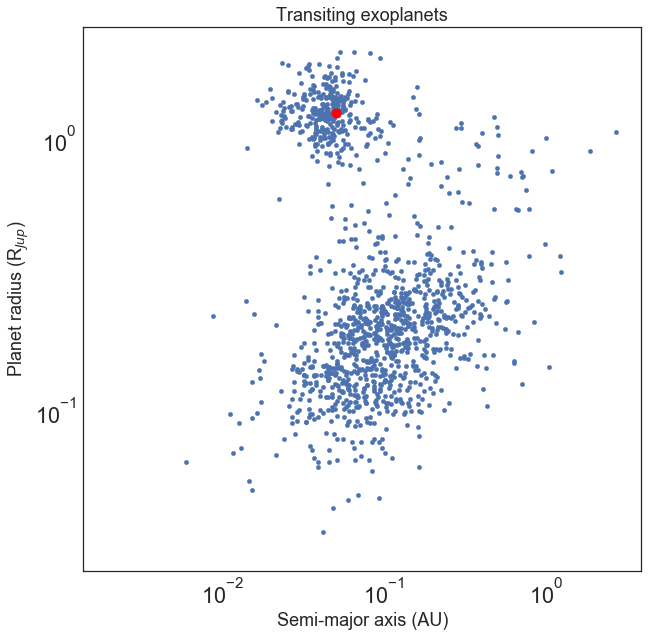

In [55]:
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'

fig,ax=plt.subplots(1,1,figsize=(10,10))

transiting = df[df['pl_discmethod'] == 'Transit']

#HAT-P-44 b
transiting.plot(x='pl_orbsmax',y='pl_radj',kind='scatter',ax=ax)
#sample.plot(x='pl_orbsmax',y='pl_radj',kind='kde',ax=ax, ylim=(1e-2,1e2))
ax.plot(hatp44b['pl_orbsmax'],hatp44b['pl_radj'], 'ro', ms=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Semi-major axis (AU)',fontsize=fontsize)
ax.set_ylabel('Planet radius (R$_{Jup}$)',fontsize=fontsize)
ax.set_title('Transiting exoplanets',fontsize=fontsize)

## Density

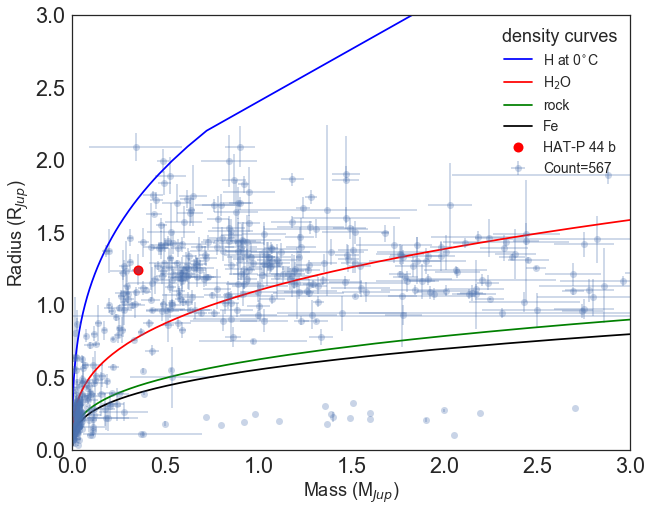

In [56]:
import numpy as np

mass_h2O, mass_Fe, mass_rock, mass_H = [],[],[],[]#,[], []

rho_h2O, rho_Fe, rho_rock, rho_H= 1000, 7874, 5510, 89.88#, 11340, 21450 #kg/m3
Mjup,Rjup=1.898e27,6.9911e7

rad = df['pl_radj'].sort_values()
for r in rad*Rjup:
    mass_h2O.append(4./3.*np.pi*rho_h2O*(r)**3) #kg
    mass_Fe.append(4./3.*np.pi*rho_Fe*(r)**3) #kg
    mass_rock.append(4./3.*np.pi*rho_rock*(r)**3) #kg
    mass_H.append(4./3.*np.pi*rho_H*(r)**3) #kg
    #mass_lead.append(4./3.*np.pi*rho_lead*(r)**3) #kg
    #mass_iridium.append(4./3.*np.pi*rho_iridium*(r)**3) #kg

count=len(df.query('pl_radj > 0 and pl_bmassj > 0'))

fig, ax1 = plt.subplots(1,1,figsize=(10,8))
errbar = ax1.errorbar(x=df['pl_bmassj'], y=df['pl_radj'], 
             xerr=df['pl_bmassjerr1'], yerr=df['pl_radjerr1'],
             fmt='o', alpha=0.3, label='Count={}'.format(count))
#plt.xlim([0,13])
#plt.ylim([0,3])
   
masses=[mass_H,mass_h2O,mass_rock,mass_Fe]
labels = ['H at 0$^{\circ}$C','H$_2$O','rock','Fe']#,'Lead','Iridium']
colors=['b-','r-','g-','k-']#,'c-','m-']

for m,c,label in zip(masses,colors,labels):
     ax1.plot(np.array(m)/Mjup, rad, c,label=label)
#with HAT-P-44b
ax1.plot(hatp44b['pl_bmassj'],hatp44b['pl_radj'], 'ro', ms=10,label='HAT-P 44 b')
ax1.set_xlim([0,3])
ax1.set_ylim([0,3])
ax1.set_xlabel('Mass (M$_{Jup}$)',fontsize=fontsize)
ax1.set_ylabel('Radius (R$_{Jup}$)',fontsize=fontsize)
ax1.legend(loc=1, title='density curves', fontsize=14)

## Surface gravity

(0.1, 10000.0)

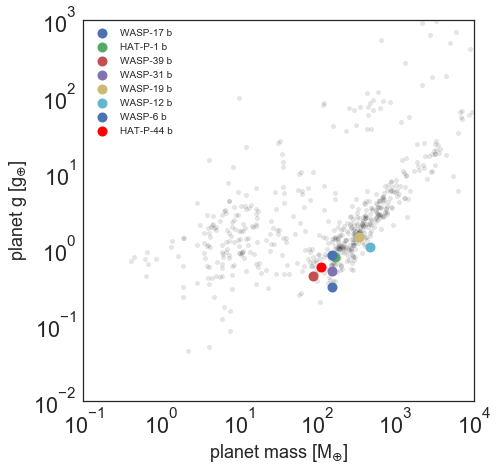

In [58]:
from astropy import constants as const

plt.style.use('seaborn-white')

HJ_planets='WASP-17,HAT-P-1,HD209458,WASP-39,WASP-31,WASP-19,WASP-12,HD189733,WASP-6'.split(',')
plot_HJ = True

plt.style.use('seaborn-white')
M_J = const.M_jup #kg
R_J = const.R_jup #m
M_E = const.M_earth
R_E = const.R_earth
G=6.67408e-11 #m3 kg-1 s-2
g_E = G*M_E/R_E**2

fig,ax=plt.subplots(1,1,figsize=(7,7))
#convert to kg and m and then to Earth units
#GM/R**2
df['pl_bmass']=df['pl_bmassj']*M_J
df['pl_bmassE']=df['pl_bmassj']*M_J/M_E
df['pl_g_E']=G/g_E*(df['pl_bmassj']*M_J)/(df['pl_radj']*R_J)**2 #not pl_logg
df.plot(x='pl_bmassE',y='pl_g_E', kind='scatter',ax=ax,alpha=0.1,color='k');
#HAT-P-44 b
hatp44b = df.query('pl_hostname == "HAT-P-44" and pl_letter == "b"')
df_HJ = hatp44b.copy()

#Sing et al. 2016 HJ
if plot_HJ==True:
    for i in HJ_planets:
        try:
            d=df.query('pl_hostname == "{}" and pl_letter == "b"'.format(i))
            d.plot(x='pl_bmassE',y='pl_g_E', marker='o',
                   ms=10,label=i+' b',ax=ax,linestyle='')
            #append querried HJ
            df_HJ=pd.concat([df_HJ,d],axis=0)
        except:
            pass
ax.plot(hatp44b['pl_bmassE'],hatp44b['pl_g_E'], 'ro', ms=10,label='HAT-P-44 b')
ax.set_xlabel('planet mass [M$_{\oplus}$]',fontsize=fontsize)
ax.set_ylabel('planet g [g$_{\oplus}$]',fontsize=fontsize)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2,1e3)
ax.set_xlim(1e-1,1e4)

## comparison with Sing et al. 2016

In [85]:
planets ='WASP-17b,WASP-39b,WASP-19b,HAT-P-1b,WASP-31b,WASP-12b,HAT-P-12b,HD189733b,WASP-6b,WASP-121b,HD209458b'.split(',')

#save each df into a dictionary, DF
DF={}

for i in planets:
    url='http://www.astro.ex.ac.uk/people/sing/spectra/'+i+'.model.txt'
    print(i)#url
    try:
        d=pd.read_table(url, sep=' ',skiprows=6)
        df2=d[d.columns[[1,-1]]]
        df2.name = str(i)
        df2.columns=['Wavelength','Rp/Rs']
        DF[i]=df2
        DF[i].set_index('Wavelength', inplace=True)
    except Exception as e:
        print(e)
        
#remove no data
del DF['HAT-P-12b']

WASP-17b
WASP-39b
WASP-19b
HAT-P-1b
WASP-31b
WASP-12b
HAT-P-12b
HD189733b
WASP-6b
WASP-121b
Error tokenizing data. C error: Expected 13 fields in line 2505, saw 14

HD209458b


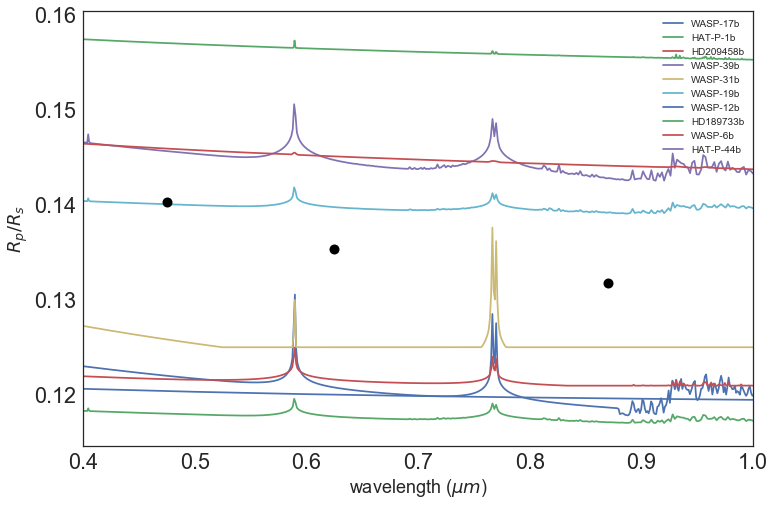

In [97]:
#to plot spectrum one by one

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
normed=False
if normed==True:
    for i in DF.keys():
        ax.plot(DF[i].index,DF[i]['Rp/Rs']/np.max(DF[i]['Rp/Rs']),
                linestyle='--',label=i)
        #
        slop,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
    #superpose HAT-P-44b
    ax.plot(xmean/1e3,pv[:3]/np.max(pv[:3]),'ko',ms=10)
    fit=slope*np.array(wavelengths)+intercept
    ax.plot(wavelengths/1e3,fit/np.max(fit),'-',label='HAT-P-44b')
    ax.legend(loc='lower left',fontsize=10)
else:
    for i in DF.keys():
        ax.plot(DF[i].index,DF[i]['Rp/Rs'],label=i)
    #superpose HAT-P-44b
    ax.plot(xmean/1e3,pv[:3],'ko',ms=10)
    ax.plot(wavelengths/1e3,slope*np.array(wavelengths)+intercept,'-',label='HAT-P-44b')
    ax.legend(loc='upper right',fontsize=10)
#optical region only
ax.set_xlim([0.4,1]) #optical
#ax.set_xlim([1,3]) #NIR
ax.set_xlabel(r'wavelength ($\mu m$)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_s$',fontsize=fontsize)

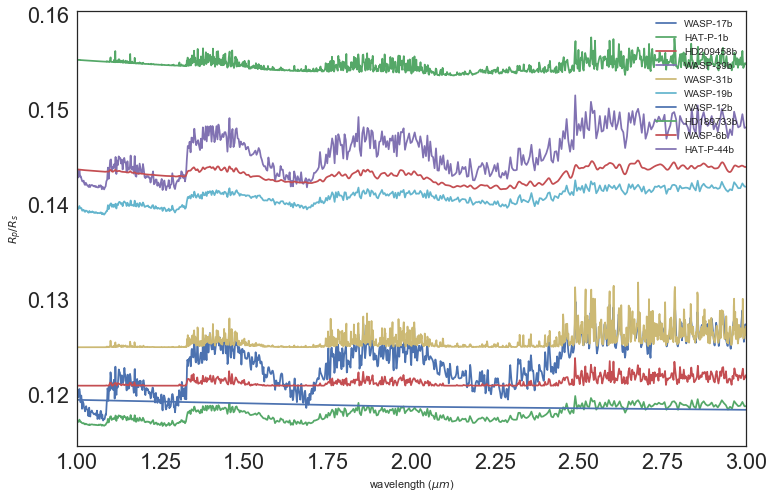

In [96]:
#to plot spectrum one by one

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
normed=False
if normed==True:
    for i in DF.keys():
        ax.plot(DF[i].index,DF[i]['Rp/Rs']/np.max(DF[i]['Rp/Rs']),
                linestyle='--',label=i)
        #
        slop,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
    #superpose HAT-P-44b
    ax.plot(xmean/1e3,pv[:3]/np.max(pv[:3]),'ko',ms=10)
    fit=slope*np.array(wavelengths)+intercept
    #ax.plot(wavelengths/1e3,fit/np.max(fit),'-',label='HAT-P-44b')
    #ax.legend(loc='lower left',fontsize=10)
else:
    for i in DF.keys():
        ax.plot(DF[i].index,DF[i]['Rp/Rs'],label=i)
    #superpose HAT-P-44b
    ax.plot(xmean/1e3,pv[:3],'ko',ms=10)
    ax.plot(wavelengths/1e3,slope*np.array(wavelengths)+intercept,'-',label='HAT-P-44b')
    ax.legend(loc='best',fontsize=10,facecolor='w')
#optical region only
#ax.set_xlim([0.4,1]) #optical
ax.set_xlim([1,3]) #NIR
ax.set_xlabel(r'wavelength ($\mu m$)')
ax.set_ylabel(r'$R_p/R_s$')

In [95]:
plt.legend?

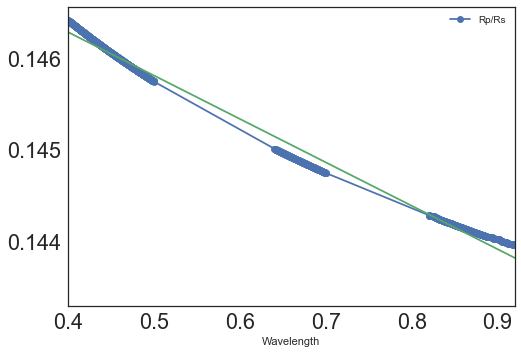

In [76]:
fig,ax=plt.subplots(1,1)
d1=DF[i][(DF[i].index>=xs1[0]/1e3) & (DF[i].index<500/1e3)]#.plot(ax=ax, marker='o')
d2=DF[i][(DF[i].index>=640/1e3) & (DF[i].index<=xs2[1]/1e3)]#.plot(ax=ax, marker='o')
d3=DF[i][(DF[i].index>=xs1[2]/1e3) & (DF[i].index<=xs2[2]/1e3)]#.plot(ax=ax, marker='o')
d=pd.concat([d1,d2,d3])
d.plot(ax=ax, marker='o')
slope,intercept,rvalue,pvalue,stderr=lg(d.index,d['Rp/Rs'])
wavelengths=np.arange(.4,1,0.001)
ax.plot(wavelengths,slope*np.array(wavelengths)+intercept)

plot only the slope given points in the g,r,z-bands

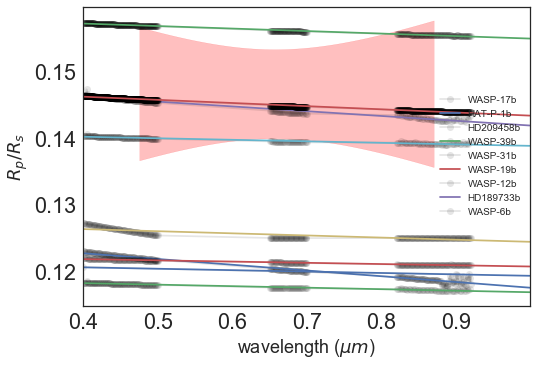

In [88]:
fig,ax=plt.subplots(1,1)
HJ_slopes={}

xs2_new=500 #exclude Na absorption (arbitrary choice)
xs1_new=650

for i in DF.keys():
    d1=DF[i][(DF[i].index>=xs1[0]/1e3) & (DF[i].index<xs2_new/1e3)]
    d2=DF[i][(DF[i].index>=xs1_new/1e3) & (DF[i].index<=xs2[1]/1e3)]
    d3=DF[i][(DF[i].index>=xs1[2]/1e3) & (DF[i].index<=xs2[2]/1e3)]
    d=pd.concat([d1,d2,d3])
    d.plot(ax=ax, marker='o',color='k',alpha=0.1)
    slope,intercept,rvalue,pvalue,stderr=lg(d.index,d['Rp/Rs'])
    wavelengths=np.arange(.4,1,0.001)
    ax.plot(wavelengths,slope*np.array(wavelengths)+intercept,label=i)
    HJ_slopes[i]=slope
#hat-p44
hatp44_slope,hatp44_intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(0.4,1e-3,0.001)
ax.plot(wavelengths,hatp44_slope*np.array(wavelengths)+hatp44_intercept,'m-')
lcb, ucb, x = confband(xmean/1e3, ys, hatp44_slope, hatp44_intercept, conf=0.841) #xdelta, ydelta, m, b
ax.fill_between(x, lcb, ucb, alpha=0.25, color='r', label='$1-\sigma$');

ax.legend(DF.keys())
ax.set_xlabel(r'wavelength ($\mu m$)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_s$',fontsize=fontsize)

In [89]:
HJ_slopes['HAT-P-44b'] = hatp44_slope
HJ_slopes

{'HAT-P-1b': -0.0022821239620240208,
 'HAT-P-44b': -1.7720879201374915e-05,
 'HD189733b': -0.0037760693999054351,
 'HD209458b': -0.0018474611496702993,
 'WASP-12b': -0.0021227894736842237,
 'WASP-17b': -0.0086587021949125053,
 'WASP-19b': -0.0022835671438588899,
 'WASP-31b': -0.0031951683485184146,
 'WASP-39b': -0.007199178862976564,
 'WASP-6b': -0.0047601380286046878}

## Density

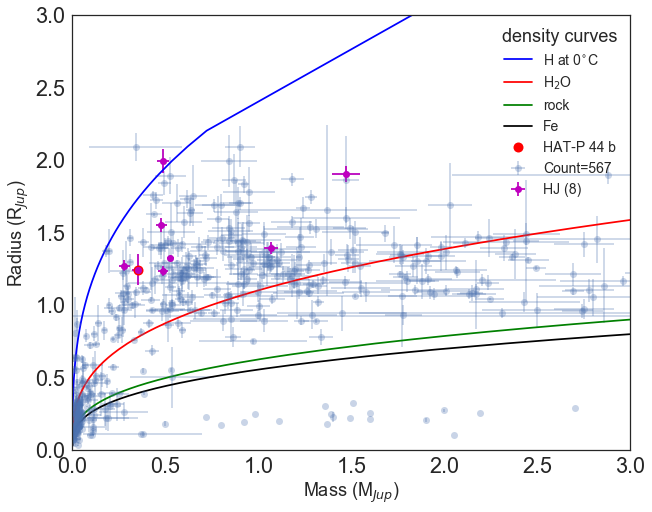

In [90]:
import numpy as np
plot_HJ = True

mass_h2O, mass_Fe, mass_rock, mass_H = [],[],[],[]#,[], []

rho_h2O, rho_Fe, rho_rock, rho_H= 1000, 7874, 5510, 89.88#, 11340, 21450 #kg/m3
Mjup,Rjup=1.898e27,6.9911e7

#rad = df['pl_radj'].sort_values()
for r in rad*Rjup:
    mass_h2O.append(4./3.*np.pi*rho_h2O*(r)**3) #kg
    mass_Fe.append(4./3.*np.pi*rho_Fe*(r)**3) #kg
    mass_rock.append(4./3.*np.pi*rho_rock*(r)**3) #kg
    mass_H.append(4./3.*np.pi*rho_H*(r)**3) #kg
    #mass_lead.append(4./3.*np.pi*rho_lead*(r)**3) #kg
    #mass_iridium.append(4./3.*np.pi*rho_iridium*(r)**3) #kg

count=len(df.query('pl_radj > 0 and pl_bmassj > 0'))

fig, ax1 = plt.subplots(1,1,figsize=(10,8))
errbar = ax1.errorbar(x=df['pl_bmassj'], y=df['pl_radj'], 
             xerr=df['pl_bmassjerr1'], yerr=df['pl_radjerr1'],
             fmt='o', alpha=0.3, label='Count={}'.format(count))
#plt.xlim([0,13])
#plt.ylim([0,3])
if plot_HJ:
    #transiting.plot(x='pl_bmassj',y='pl_radj',kind='scatter',alpha=0.1,ax=ax)
    ax1.errorbar(x=df_HJ['pl_bmassj'], y=df_HJ['pl_radj'], 
             xerr=df_HJ['pl_bmassjerr1'], yerr=df_HJ['pl_radjerr1'],
             fmt='o', color='m', label='HJ ({})'.format(len(df_HJ)))
    
masses=[mass_H,mass_h2O,mass_rock,mass_Fe]
labels = ['H at 0$^{\circ}$C','H$_2$O','rock','Fe']#,'Lead','Iridium']
colors=['b-','r-','g-','k-']#,'c-','m-']

for m,c,label in zip(masses,colors,labels):
     ax1.plot(np.array(m)/Mjup, rad, c,label=label)
#with HAT-P-44b
ax1.plot(hatp44b['pl_bmassj'],hatp44b['pl_radj'], 'ro', ms=10,label='HAT-P 44 b')
ax1.set_xlim([0,3])
ax1.set_ylim([0,3])
ax1.set_xlabel('Mass (M$_{Jup}$)',fontsize=fontsize)
ax1.set_ylabel('Radius (R$_{Jup}$)',fontsize=fontsize)
ax1.legend(loc=1, title='density curves', fontsize=14)

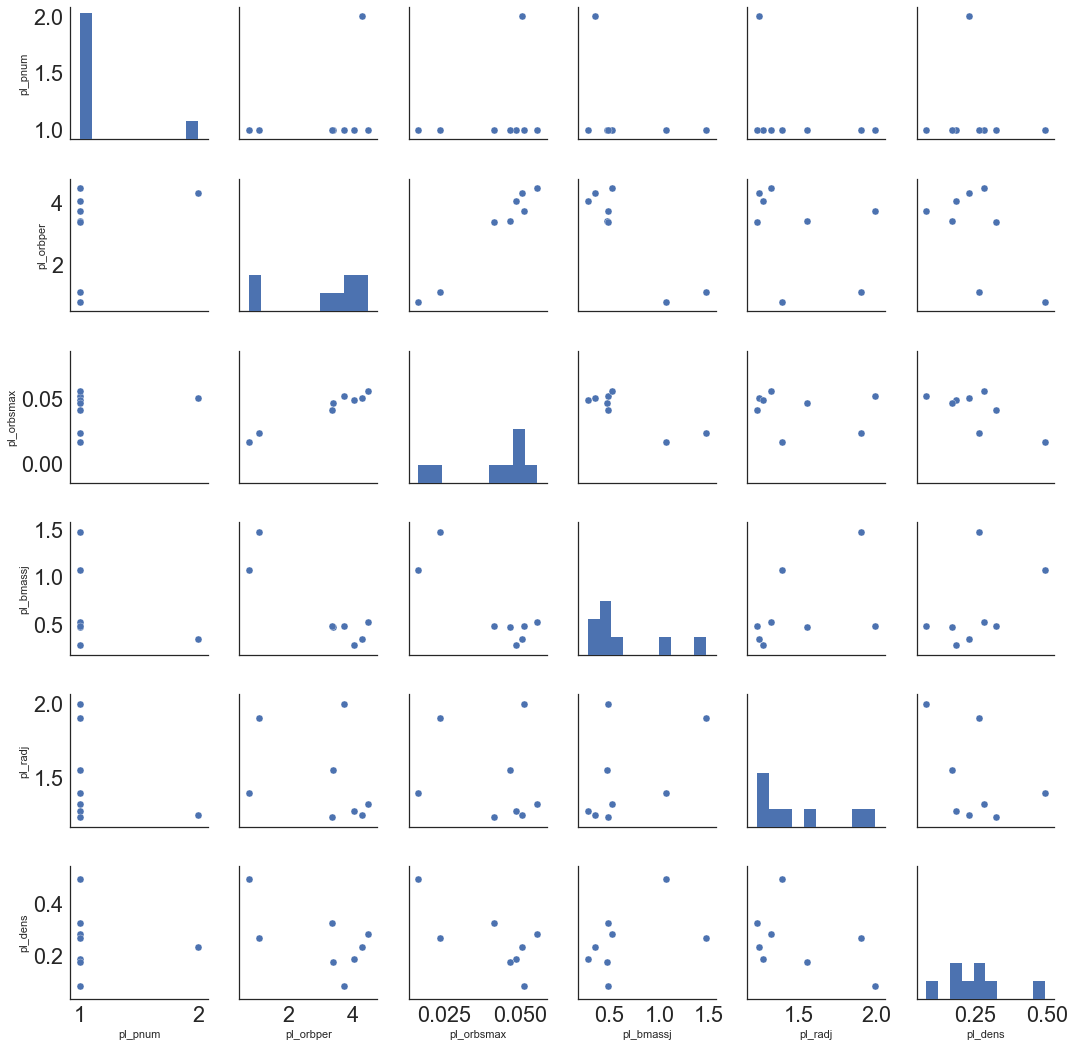

In [313]:
#pl_insol, pl_eqt are all NaN
pl_params='pl_pnum,pl_orbper,pl_orbsmax,pl_bmassj,pl_radj,pl_dens'.split(',')
sb.pairplot(data=df_HJ,vars=pl_params)

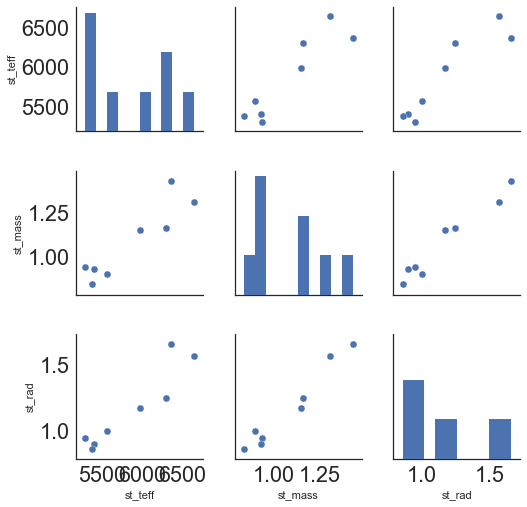

In [329]:
# ,st_dens,st_metfe,st_age,st_logg are all NaN
st_params='st_teff,st_mass,st_rad'.split(',')
for n,i in enumerate(st_params):
    if len(df_HJ[i].dropna()) == 0:
        del st_params[n]
sb.pairplot(data=df_HJ,vars=st_params)

## Linear ephemeris

$$
T_C(n)=T_0+nP
$$

In [ ]:
n=100
t0=2455696.93695 #0.00024 #bjd
for i in range(n):
    plt.plot(i,t0+n*p_,'o')
#plt.ylim(2456120,2456140)
plt.yscale('log')

In [ ]:
57799.8740914464

In [6]:
def scaled_a_from_rhop(rho, period):
    """Scaled semi-major axis from the stellar density and planet's orbital period.
    Parameters
    ----------
      rho    : stellar density [g/cm^3]
      period : orbital period  [d]
    Returns
    -------
      as : scaled semi-major axis [R_star]
    """
    return (G/(3*pi))**(1/3)*((period*d_s)**2 * 1e3*rho)**(1/3)

def a_from_rhoprs(rho, period, rstar):
    """Semi-major axis from the stellar density, stellar radius, and planet's orbital period.
    Parameters
    ----------
      rho    : stellar density [g/cm^3]
      period : orbital period  [d]
      rstar  : stellar radius  [R_Sun]
    Returns
    -------
      a : semi-major axis [AU]
    """
    return as_from_rhop(rho,period)*rstar*rsun/au

def a_from_mp(ms, period):
    """Semi-major axis from the stellar mass and planet's orbital period.
    Parameters
    ----------
      ms     : stellar mass    [M_Sun]
      period : orbital period  [d]
    Returns
    -------
      a : semi-major axis [AU]
    """
    return ((G*(ms*msun)*(period*d_s)**2)/(4*pi**2))**(1/3)/au

def estimate_k(t,f,p,showfig=False):
    '''
    k=Rp/Rs estimate transit depth assumed to be within 0.01 percentile
    '''
    baseline,minimum=np.percentile(f[np.array(t%p).argsort()], [50,1])
    if showfig:
        pl.hist(f[np.array(t%p).argsort()]);
    #print(baseline,minimum)
    return np.sqrt(baseline-minimum)

def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = inclination(a, b)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

def t14_circ(p, a, k, b):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    i = inclination(a, b)
    alpha = np.sqrt( (1 + k)**2 - b**2 )
    return (p / np.pi) * np.arcsin( alpha / np.sin(i) / a )

def inclination(a, impact_param, e=None, w=None):
    """
    Winn 2014 ("Transits and Occultations"), eq. 7
    """
    # if e is None and w is None:
    #     return np.arccos(b / a)
    # elif e is not None and w is not None:
    #     return np.arccos(b / a * (1 + e * np.sin(w)) / (1 - e**2))
    # else:
    #     return np.nan
    return np.arccos(impact_param / a)